In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

df = pd.read_csv('gp_objects.csv')
display(df)
obj = sorted(df.obj_id.unique())

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0     58226.340532  136.476566   99.008275        20.225414         1.245730   
1     58226.844883  162.972272  126.219481        16.229688         2.778614   
2     58227.349233  190.825310  153.363912        12.014731         3.524496   
3     58227.853583  219.423324  180.399970         7.692804         4.826813   
4     58228.357933  248.089537  206.392050         4.061100         5.478884   
...            ...         ...         ...              ...              ...   
7196  60484.972616   32.991076   35.778804        22.383172        12.391853   
7197  60485.064772   33.120805   35.975863        21.500098         9.773389   
7198  60485.156927   33.177963   36.087816        20.818900         7.085820   
7199  60485.249083   33.157022   36.099820        20.391462         4.547957   
7200  60485.341238   33.054302   35.995481        20.256452         3.185979   

     type        obj_id         mjd_0 redshift  flux_ztfi  ...   mag_ztfg  \
0     Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.562355   
1     Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.369716   
2     Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.198410   
3     Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.046793   
4     Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  17.913479   
...   ...           ...           ...      ...        ...  ...        ...   
7196   II  ZTF24aascytf  60476.217836    0.038  33.941007  ...  20.104009   
7197   II  ZTF24aascytf  60476.217836    0.038  34.034440  ...  20.099748   
7198   II  ZTF24aascytf  60476.217836    0.038  34.056312  ...  20.097876   
7199   II  ZTF24aascytf  60476.217836    0.038  34.000498  ...  20.098561   
7200   II  ZTF24aascytf  60476.217836    0.038  33.862840  ...  20.101930   

      abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
0       -13.788411        0.160903  18.910821    -13.439944        0.013661   
1       -13.981050        0.108124  18.647184    -13.703582        0.023902   
2       -14.152356        0.068360  18.435692    -13.915074        0.024952   
3       -14.303973        0.038065  18.259409    -14.091357        0.029050   
4       -14.437287        0.017773  18.113268    -14.237498        0.028822   
...            ...             ...        ...           ...             ...   
7196    -11.088855        0.736630  20.015935    -11.176929        0.376041   
7197    -11.093116        0.704797  20.009972    -11.182892        0.294957   
7198    -11.094988        0.681291  20.006599    -11.186266        0.213184   
7199    -11.094303        0.667724  20.006237    -11.186627        0.136784   
7200    -11.090934        0.665365  20.009380    -11.183484        0.096099   

       mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0           NaN           NaN             NaN  0.000000  
1           NaN           NaN             NaN  0.504350  
2           NaN           NaN             NaN  1.008700  
3           NaN           NaN             NaN  1.513051  
4           NaN           NaN             NaN  2.017401  
...         ...           ...             ...       ...  
7196  20.073188    -11.119676        0.689326  8.754780  
7197  20.070203    -11.122661        0.656982  8.846936  
7198  20.069506    -11.123358        0.632921  8.939092  
7199  20.071287    -11.121577        0.619008  9.031247  
7200  20.075692    -11.117172        0.616733  9.123403  

[7201 rows x 21 columns]

In [2]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [3]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [4]:
obj[27]

'ZTF20acozryr'

In [5]:
df[df['obj_id'] == obj[30]]

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
3000  59215.423935  85.374642  48.127260        13.369288        16.339748   
3001  59215.927739  82.379282  46.576353        12.714096        14.635375   
3002  59216.431543  79.167951  45.190039        12.281096        12.954676   
3003  59216.935347  75.844269  44.024778        11.994572        11.306383   
3004  59217.439151  72.508578  43.142565        11.779782         9.705195   
...            ...        ...        ...              ...              ...   
3095  59263.285305  26.350826  79.360612         4.481387         2.346869   
3096  59263.789109  25.788893  77.793196         6.062226         2.182467   
3097  59264.292913  25.231916  75.899615         7.771120         2.018465   
3098  59264.796717  24.671588  73.749359         9.532219         2.095826   
3099  59265.300521  24.102787  71.497819        11.314670         2.628919   

     type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
3000  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.895474  ...  19.071678   
3001  IIb  ZTF21aaabrpu  59215.423935  0.027172  38.441953  ...  19.110455   
3002  IIb  ZTF21aaabrpu  59215.423935  0.027172  39.210226  ...  19.153626   
3003  IIb  ZTF21aaabrpu  59215.423935  0.027172  40.219729  ...  19.200193   
3004  IIb  ZTF21aaabrpu  59215.423935  0.027172  41.488355  ...  19.249027   
...   ...           ...           ...       ...        ...  ...        ...   
3095  IIb  ZTF21aaabrpu  59215.423935  0.027172  92.035185  ...  20.348014   
3096  IIb  ZTF21aaabrpu  59215.423935  0.027172  90.504497  ...  20.371418   
3097  IIb  ZTF21aaabrpu  59215.423935  0.027172  88.911406  ...  20.395124   
3098  IIb  ZTF21aaabrpu  59215.423935  0.027172  87.256970  ...  20.419507   
3099  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.545123  ...  20.444832   

      abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
3000    -11.375703        0.170021  19.694022    -10.753358        0.368620   
3001    -11.336925        0.167568  19.729586    -10.717794        0.341164   
3002    -11.293754        0.168427  19.762393    -10.684987        0.311249   
3003    -11.247187        0.171706  19.790757    -10.656623        0.278837   
3004    -11.198354        0.176389  19.812735    -10.634645        0.244243   
...            ...             ...        ...           ...             ...   
3095    -10.099366        0.184647  19.150987    -11.296393        0.032108   
3096    -10.075962        0.255225  19.172646    -11.274735        0.030460   
3097    -10.052256        0.334393  19.199401    -11.247979        0.028874   
3098    -10.027873        0.419490  19.230604    -11.216776        0.030855   
3099    -10.002549        0.509682  19.264268    -11.183112        0.039922   

       mag_ztfi  abs_mag_ztfi  mag_error_ztfi          t  
3000  19.953532    -10.493849        0.746163   0.000000  
3001  19.937986    -10.509394        0.687327   0.503804  
3002  19.916502    -10.530879        0.626913   1.007608  
3003  19.888902    -10.558478        0.565901   1.511412  
3004  19.855184    -10.592196        0.505365   2.015216  
...         ...           ...             ...        ...  
3095  18.990115    -11.457265        0.085157  47.861370  
3096  19.008325    -11.439056        0.095276  48.365174  
3097  19.027606    -11.419774        0.109302  48.868978  
3098  19.048000    -11.399381        0.126538  49.372782  
3099  19.069512    -11.377869        0.146419  49.876586  

[100 rows x 21 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


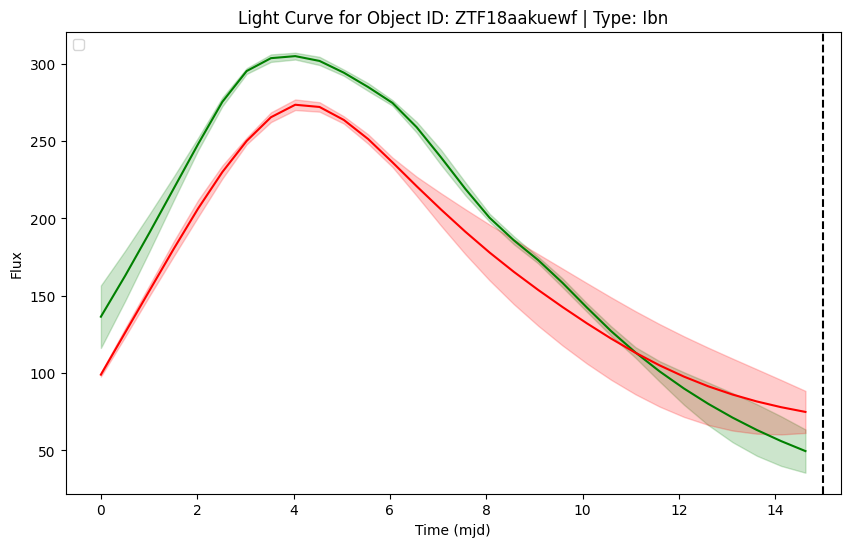

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


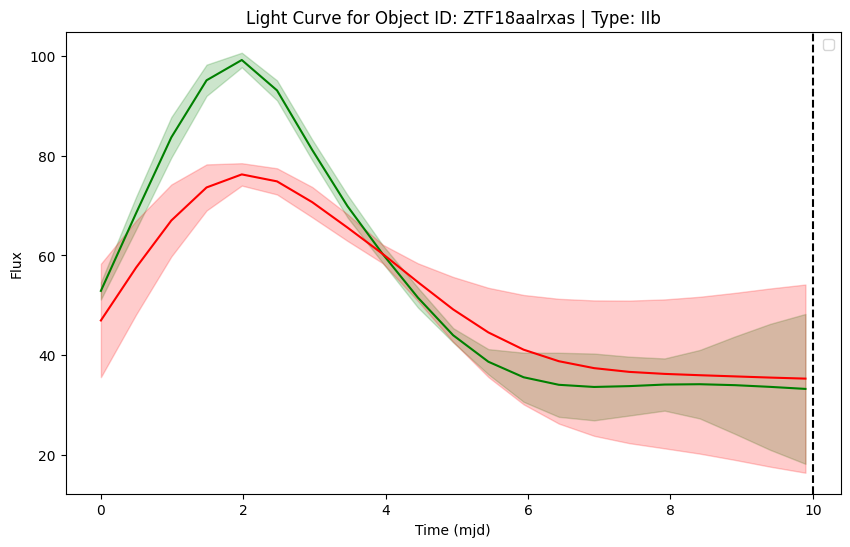

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


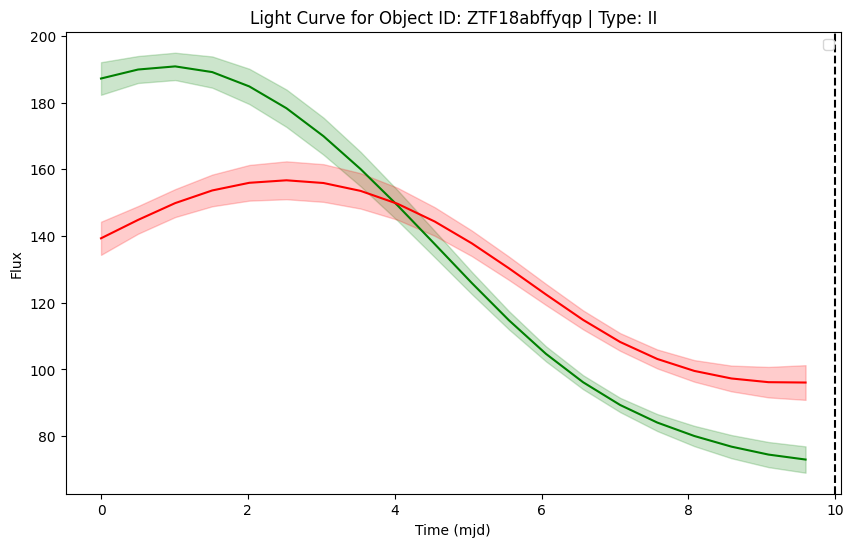

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


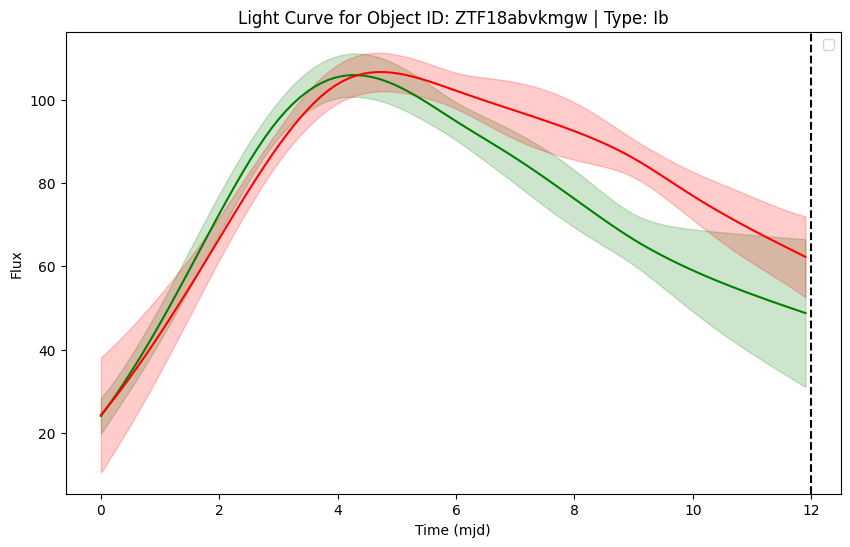

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


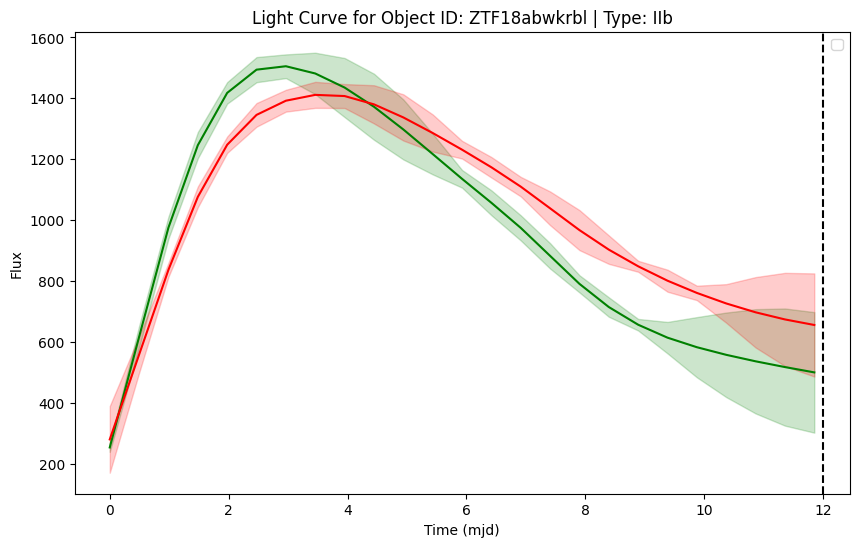

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


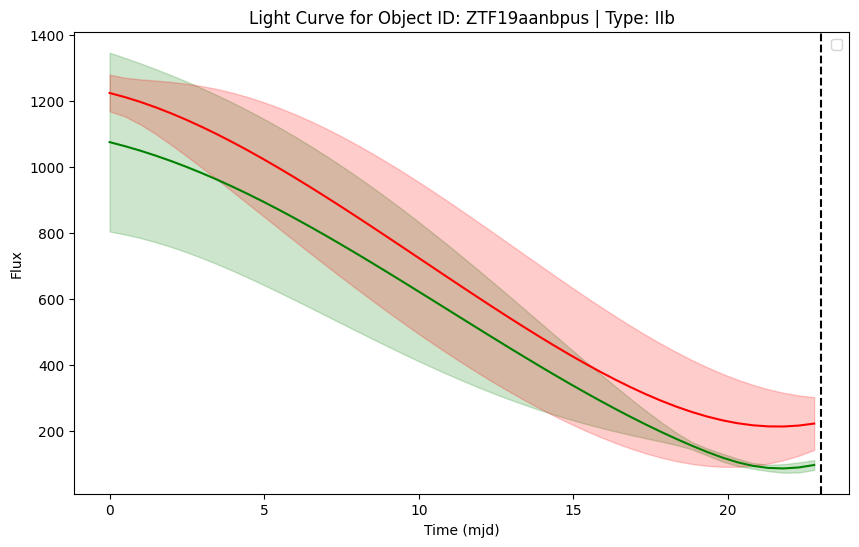

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


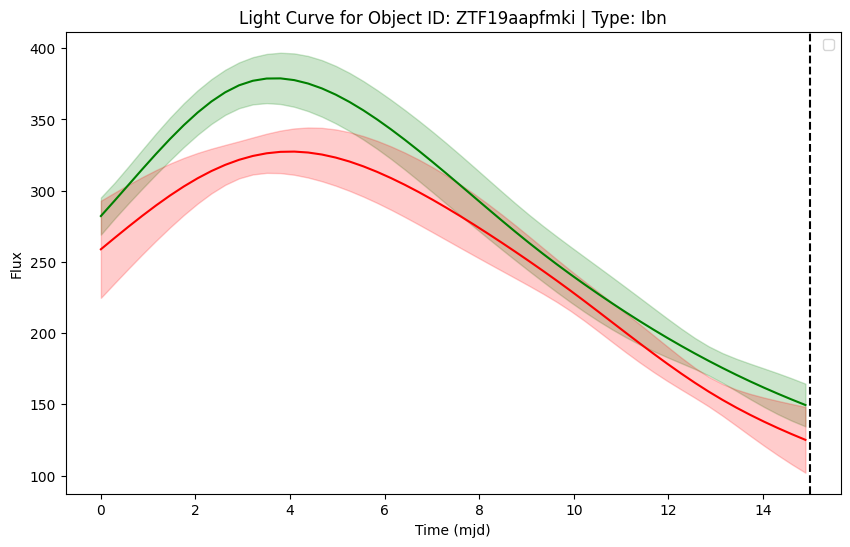

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


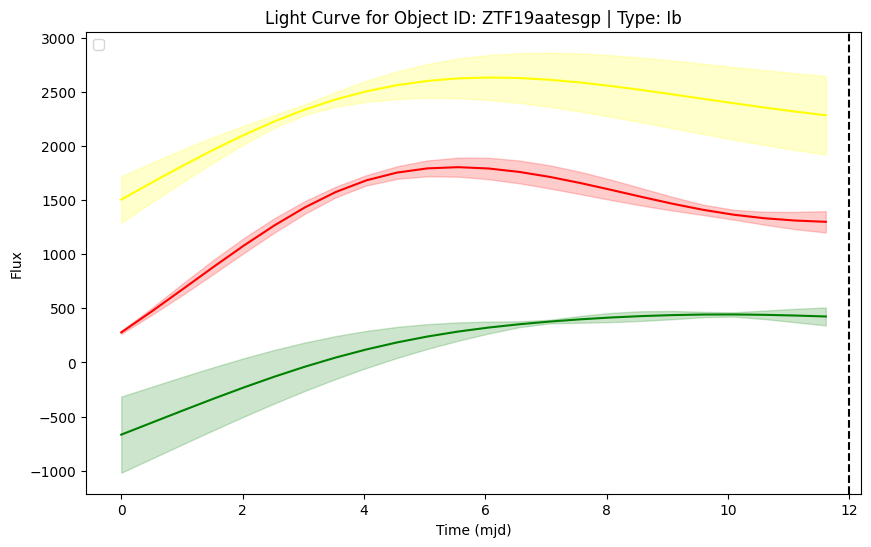

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


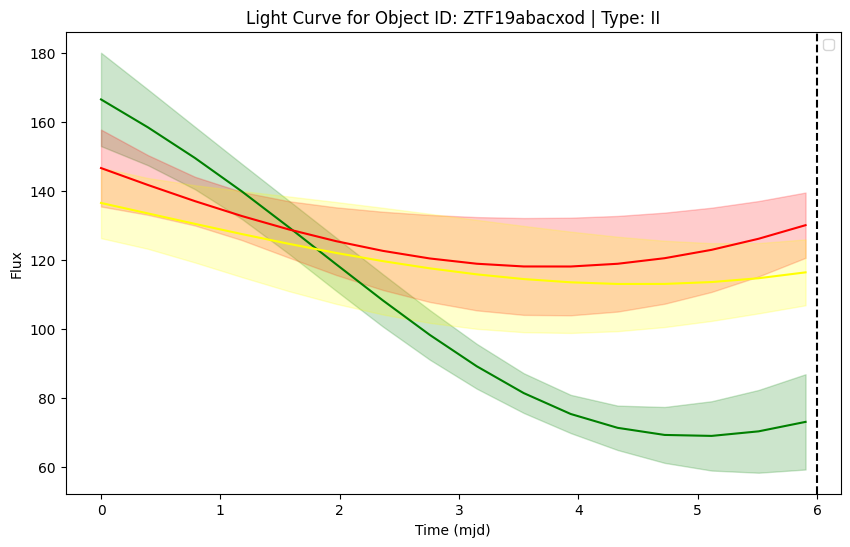

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


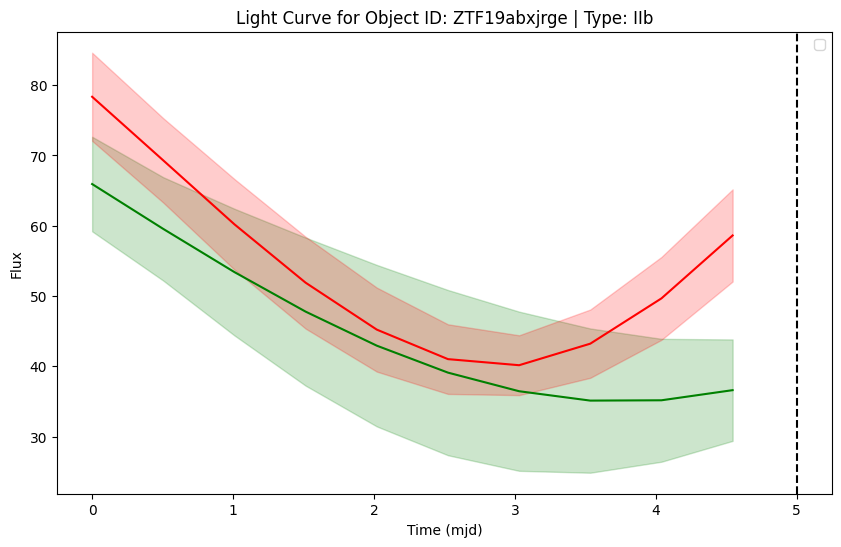

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


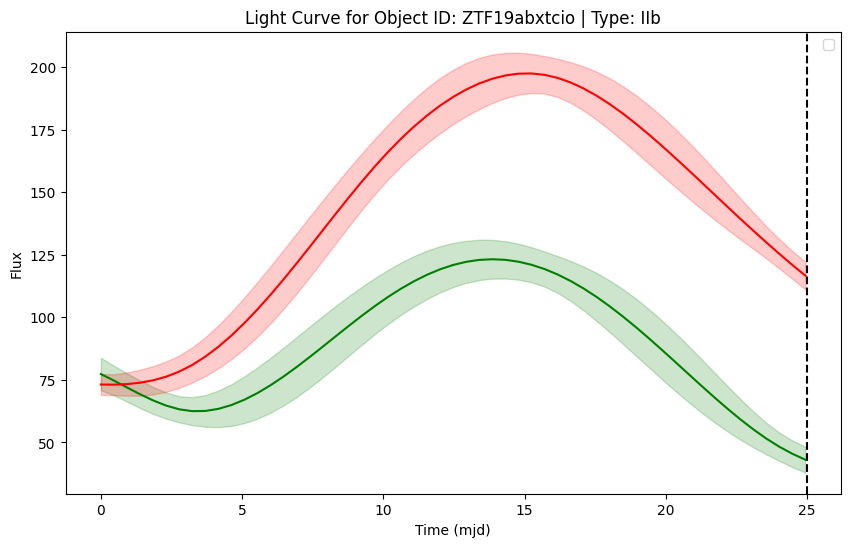

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


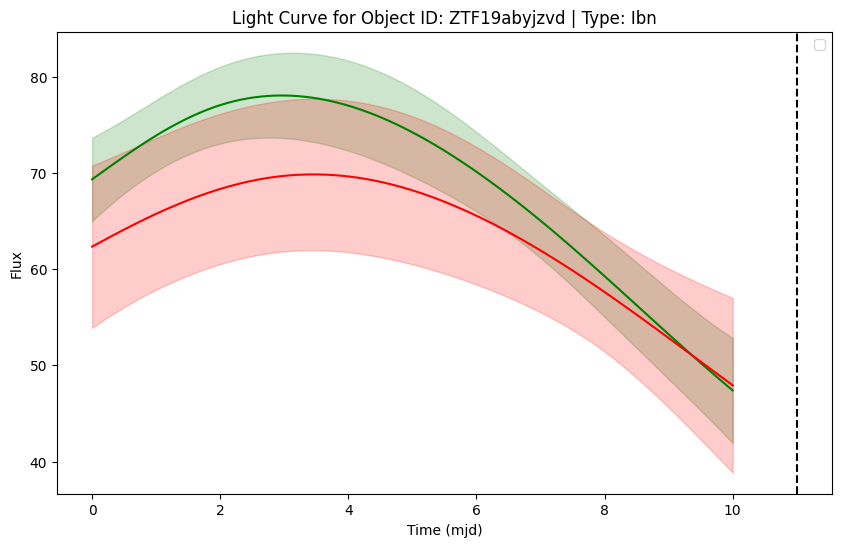

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


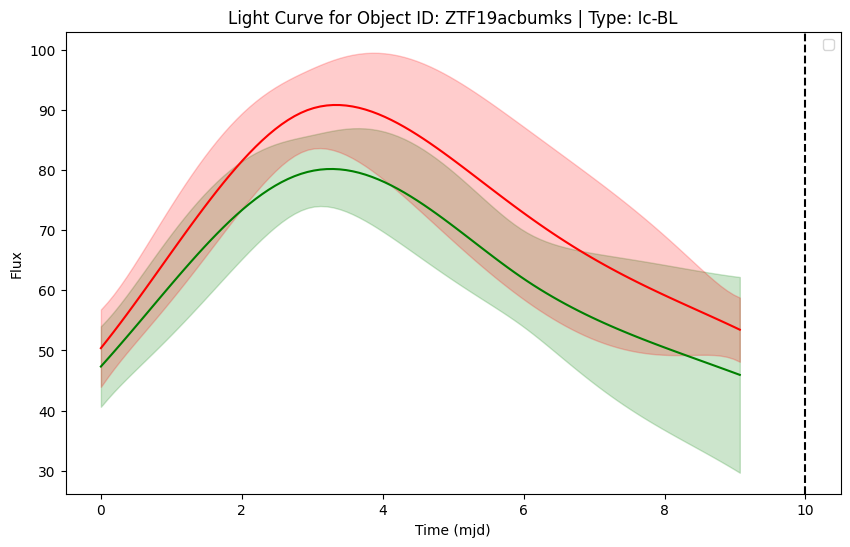

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


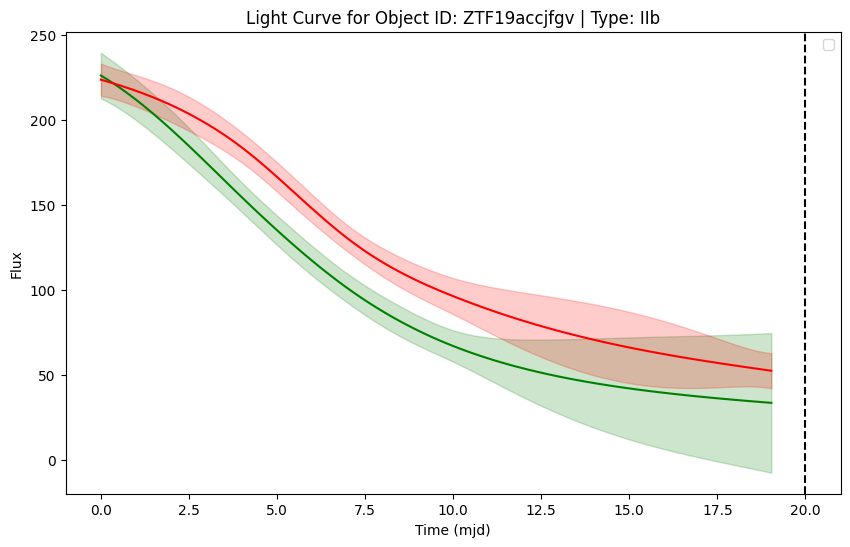

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


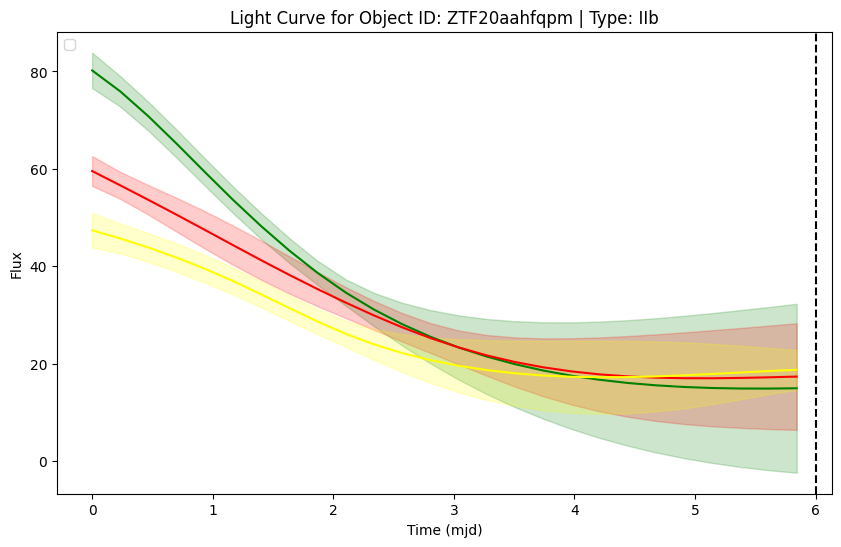

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


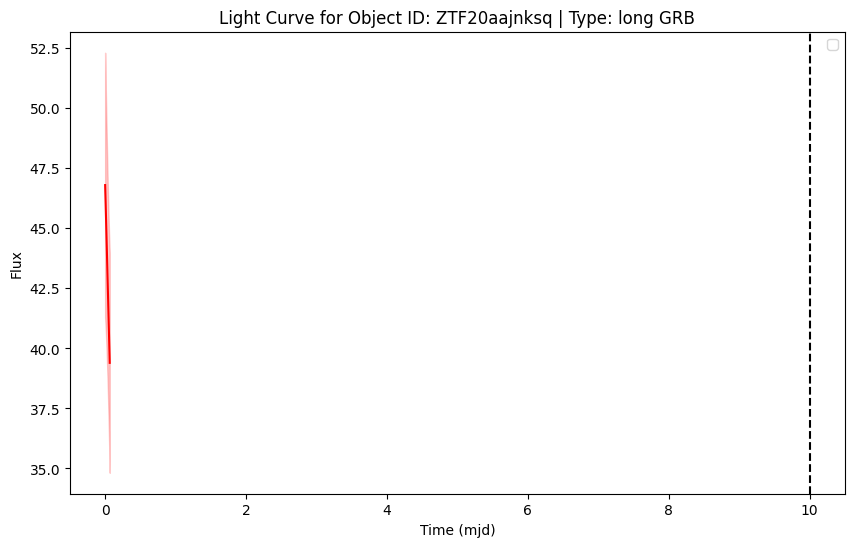

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


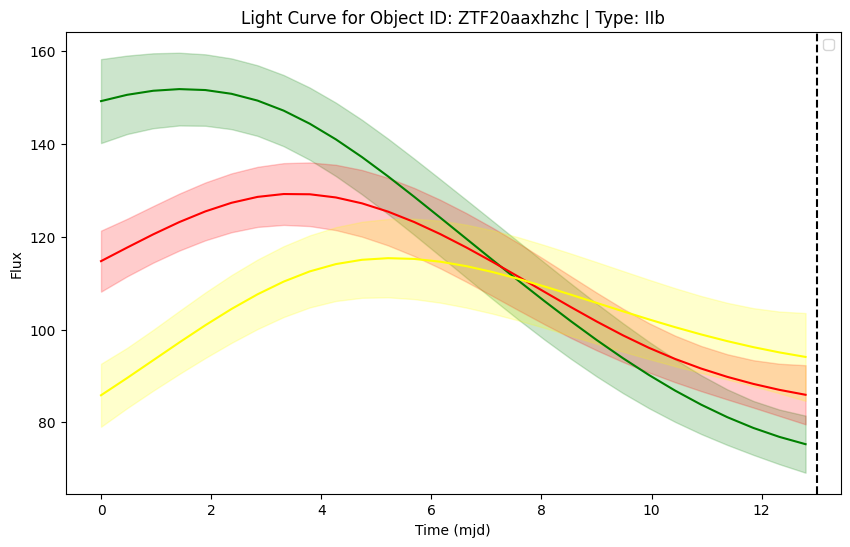

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


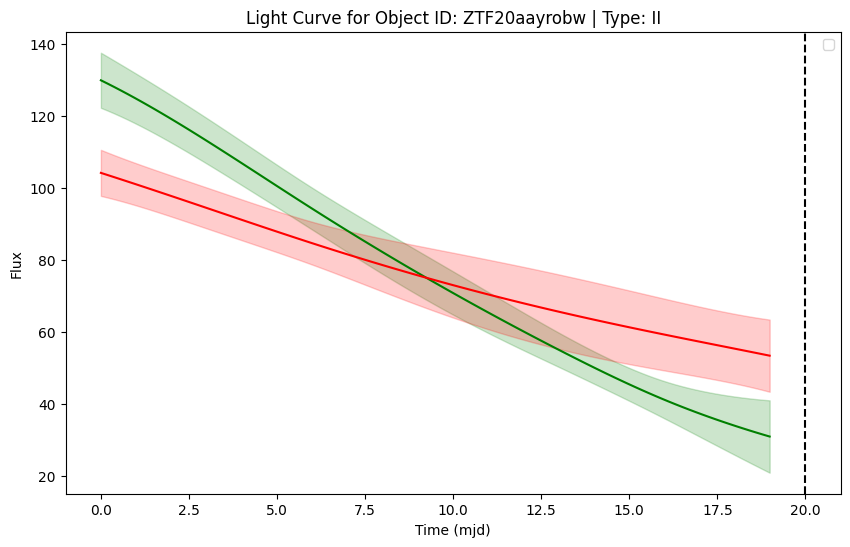

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


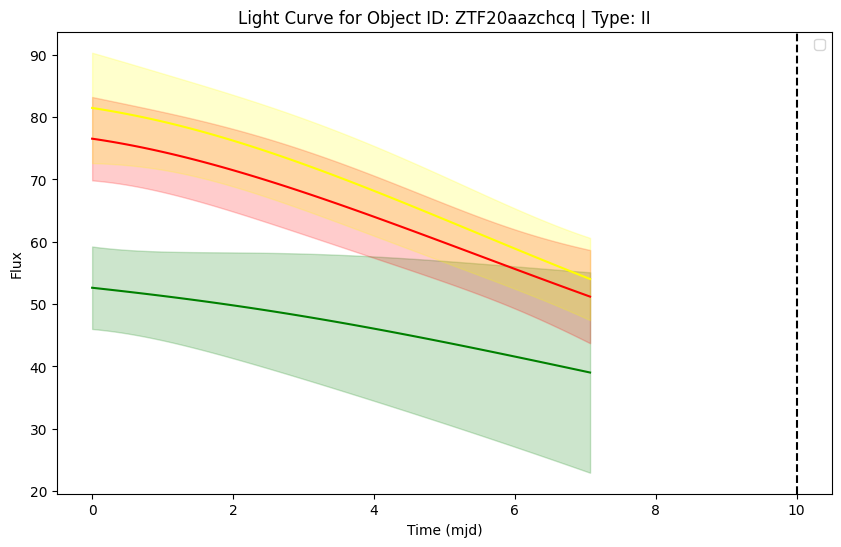

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


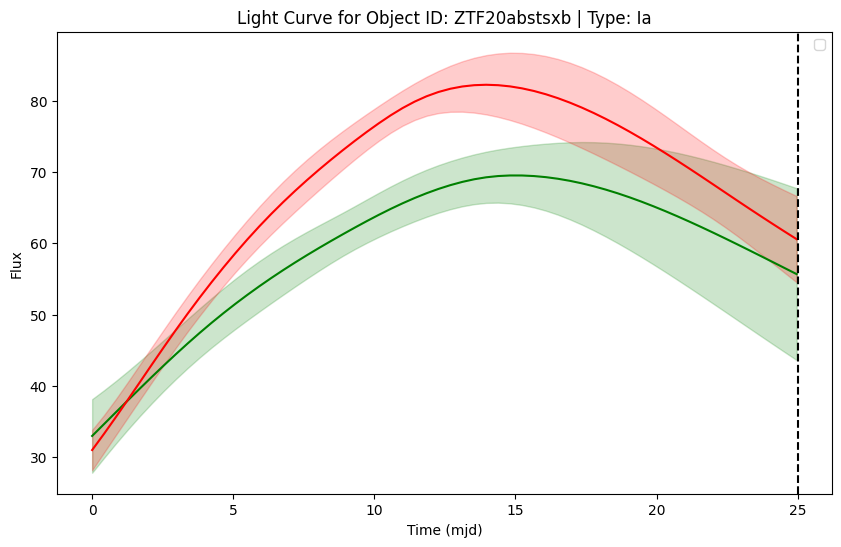

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


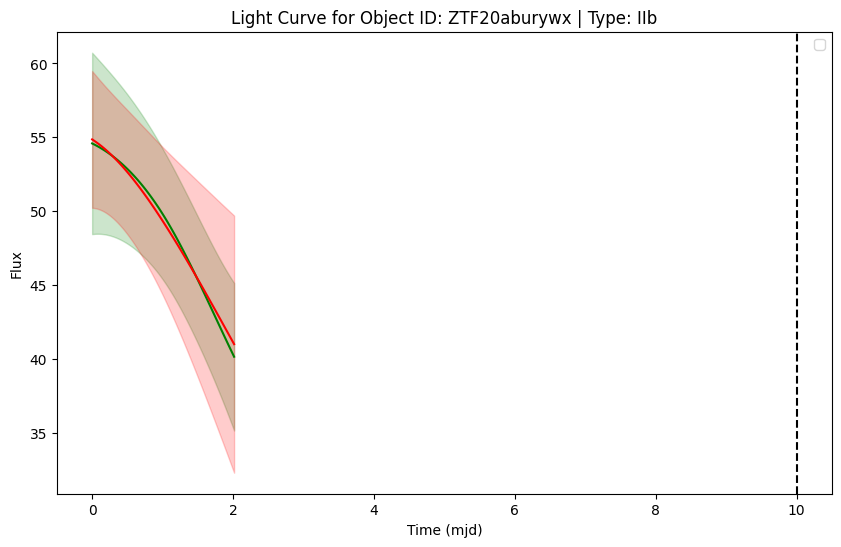

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


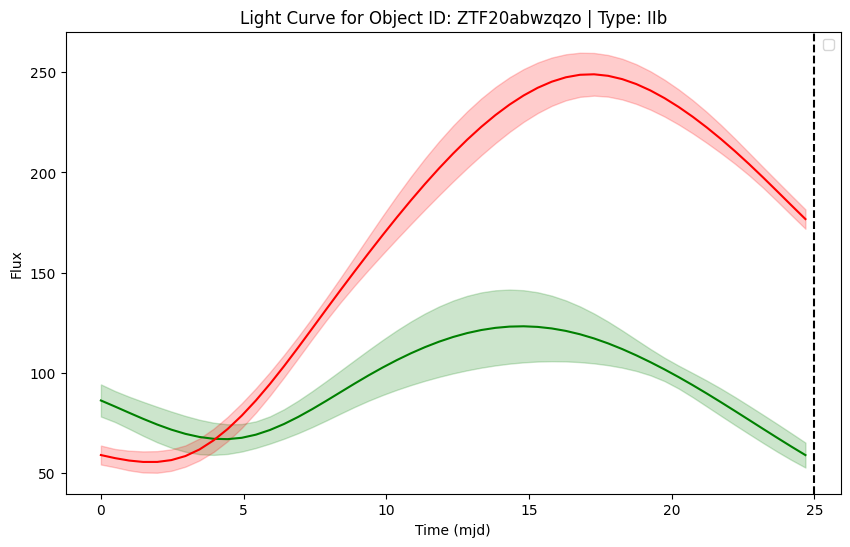

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


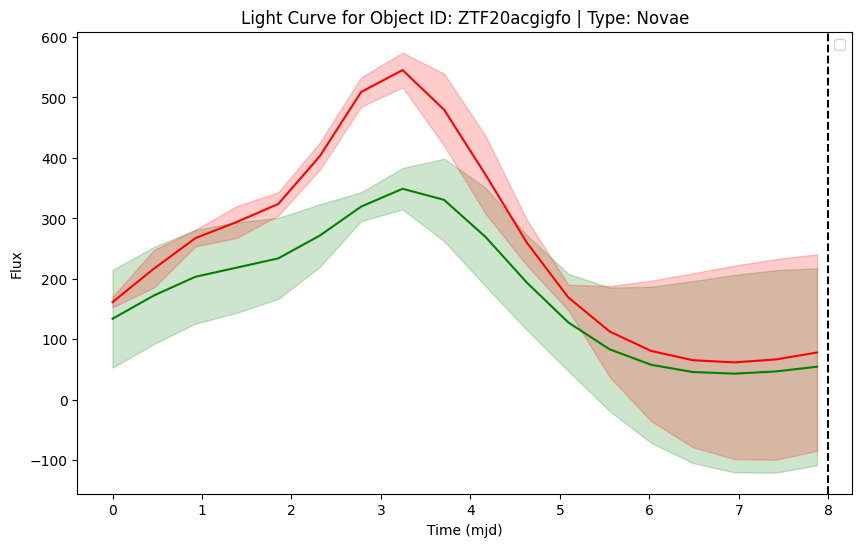

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


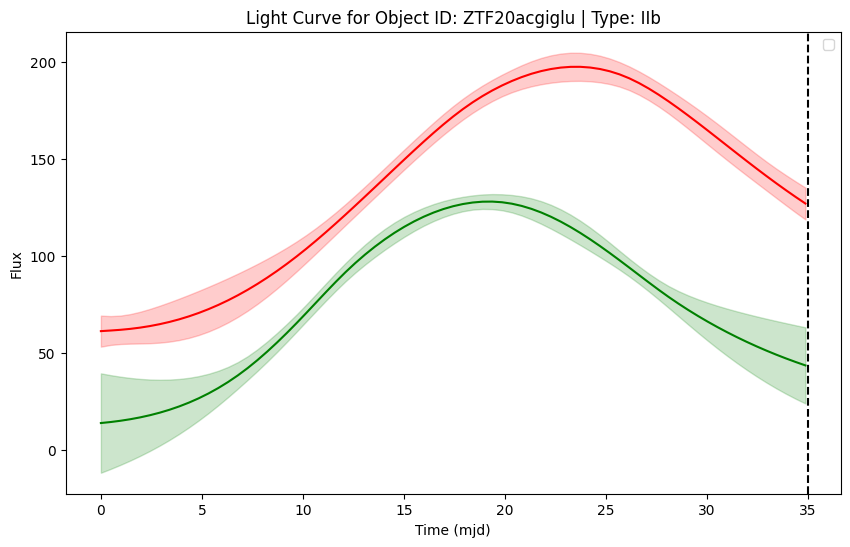

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


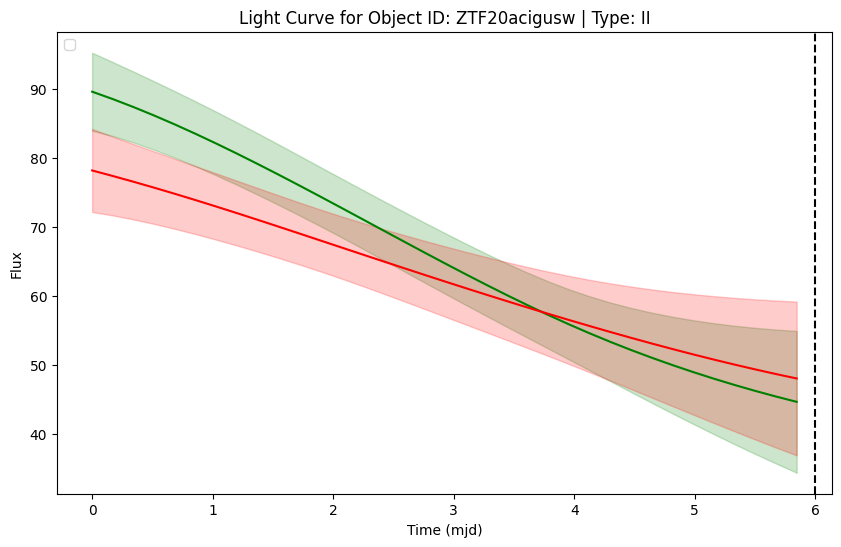

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


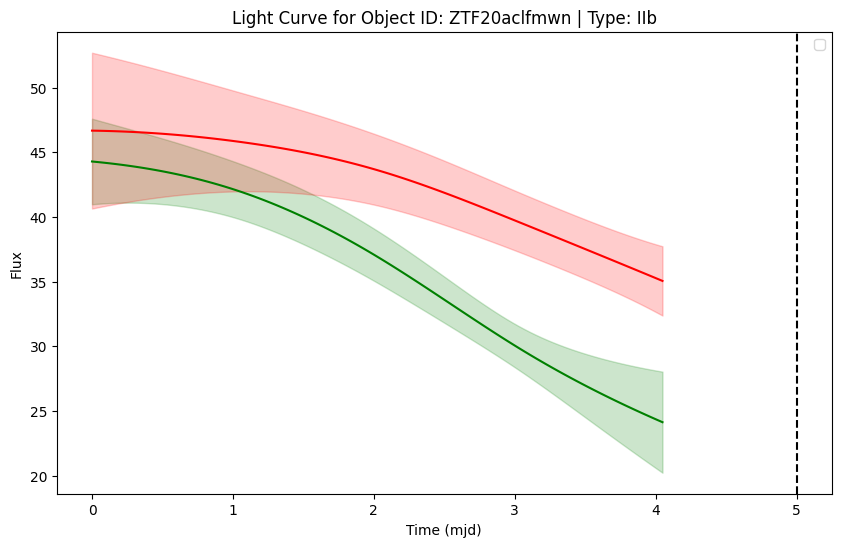

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


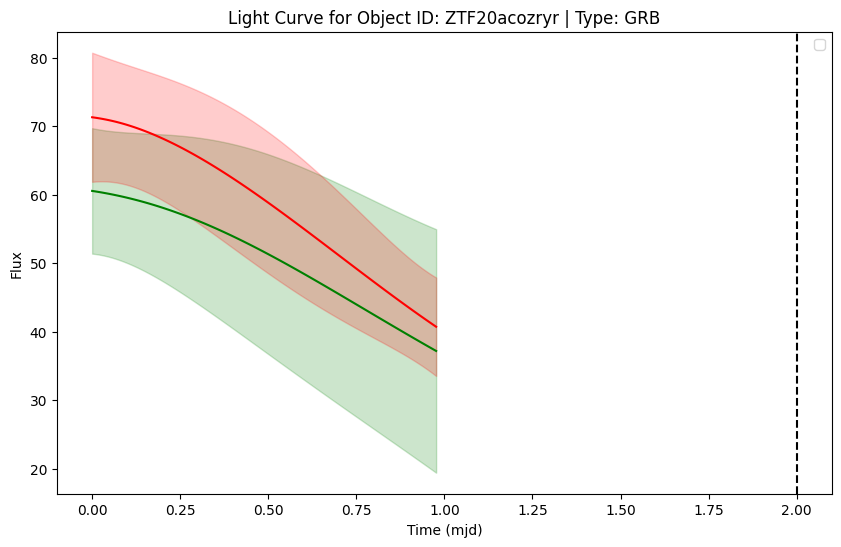

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


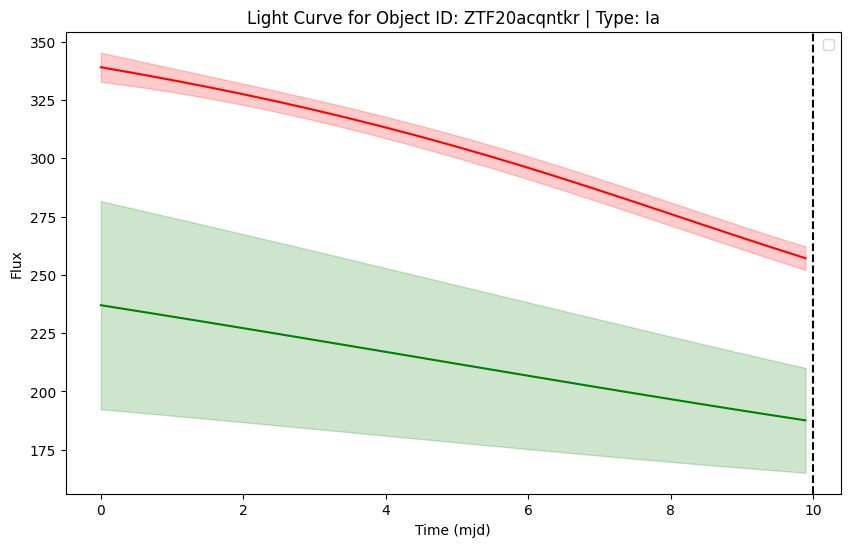

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


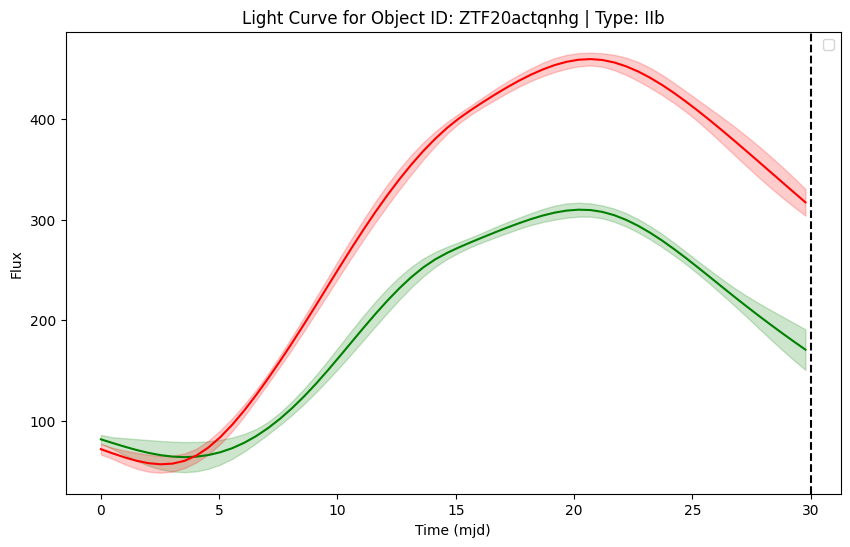

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


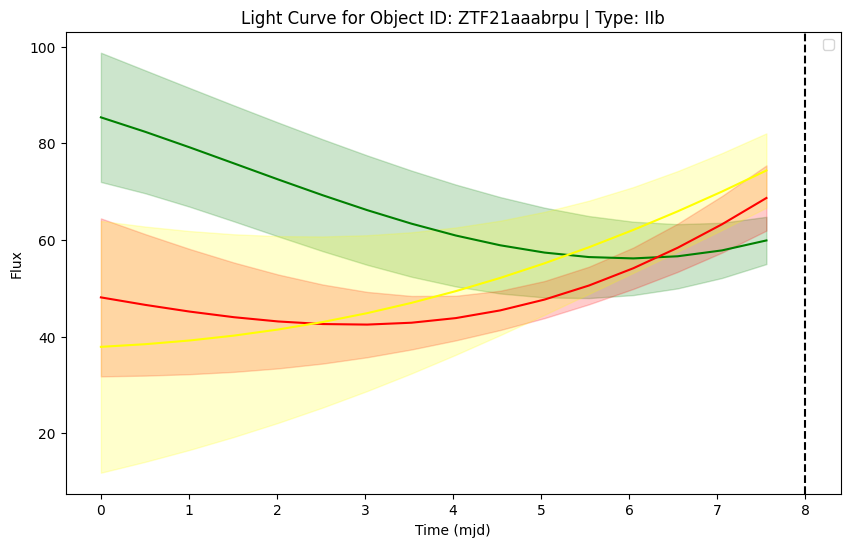

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


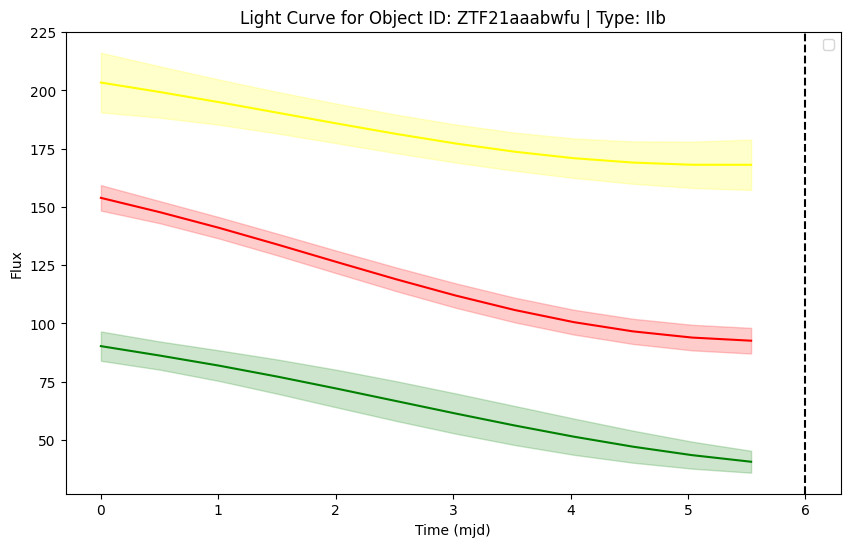

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


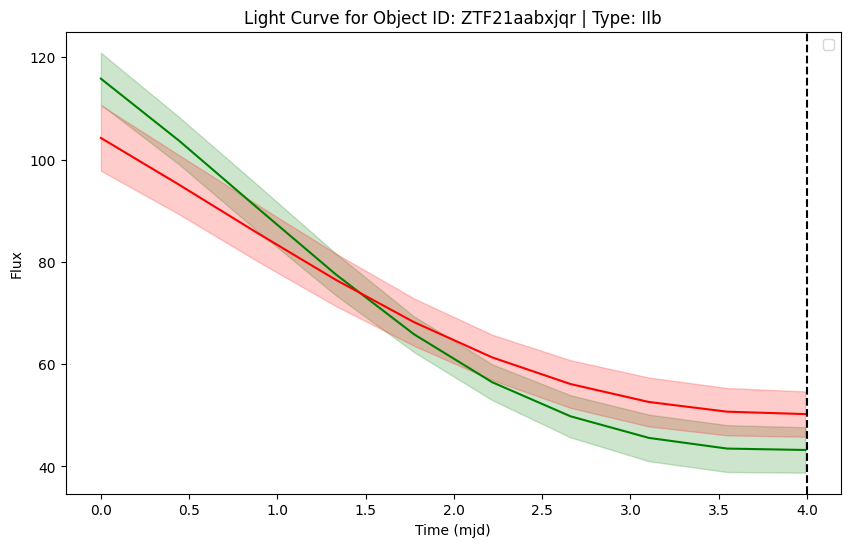

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


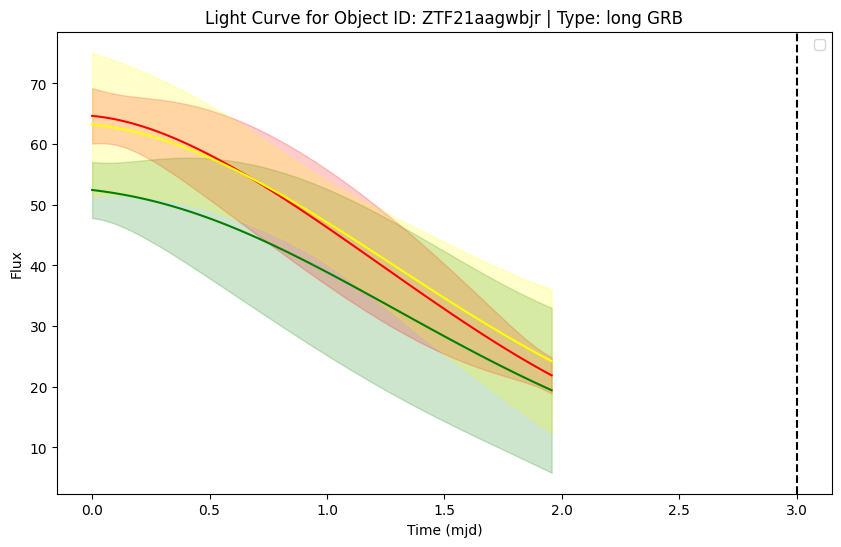

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


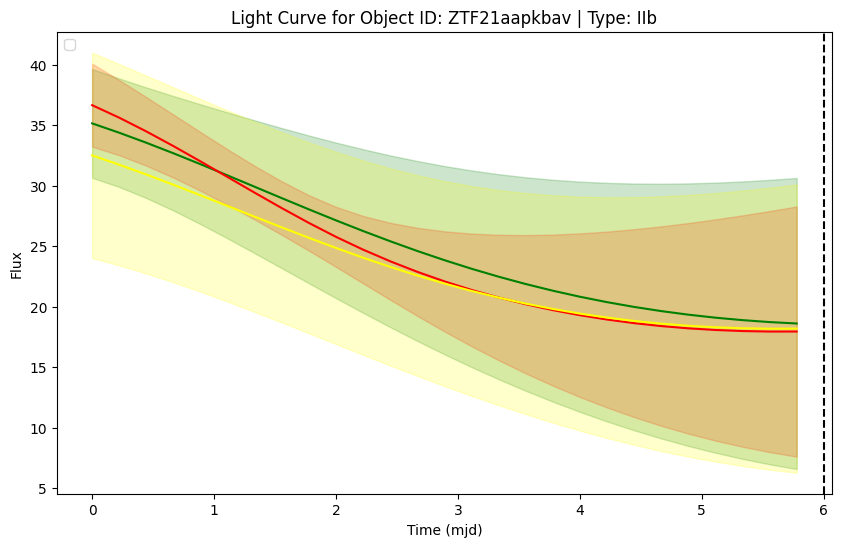

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


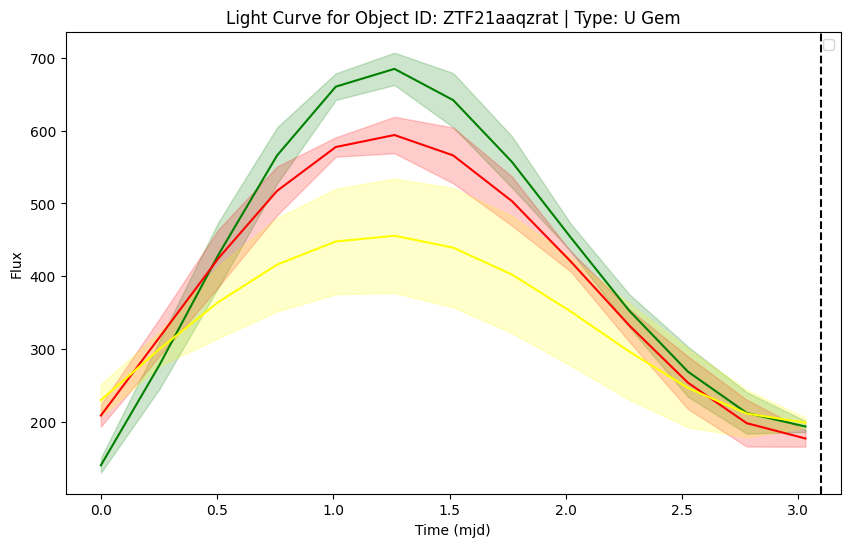

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


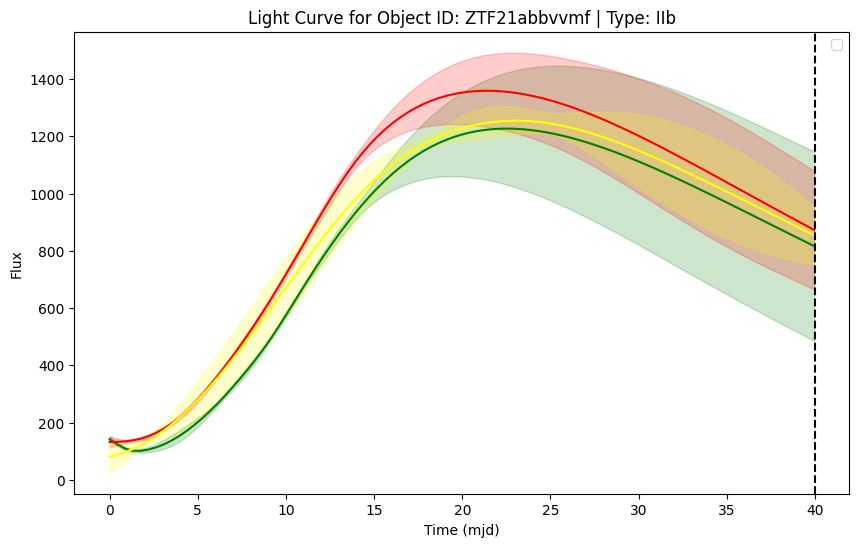

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


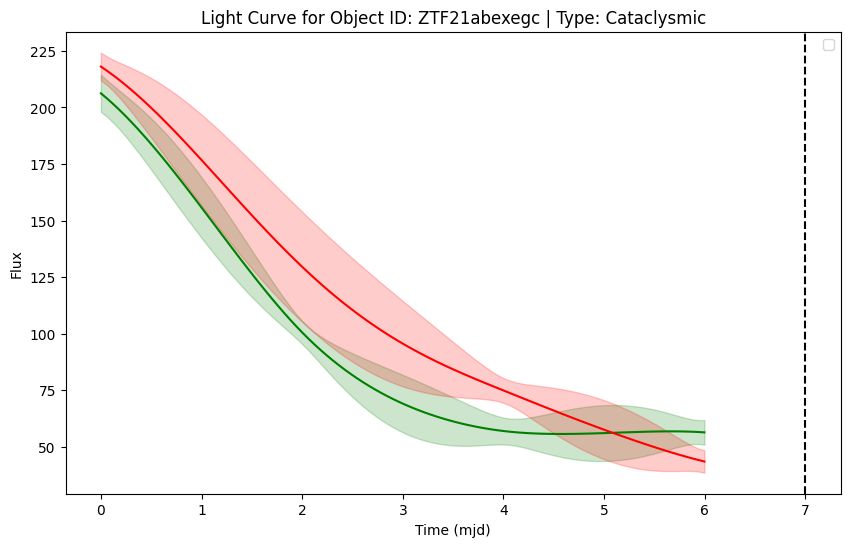

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


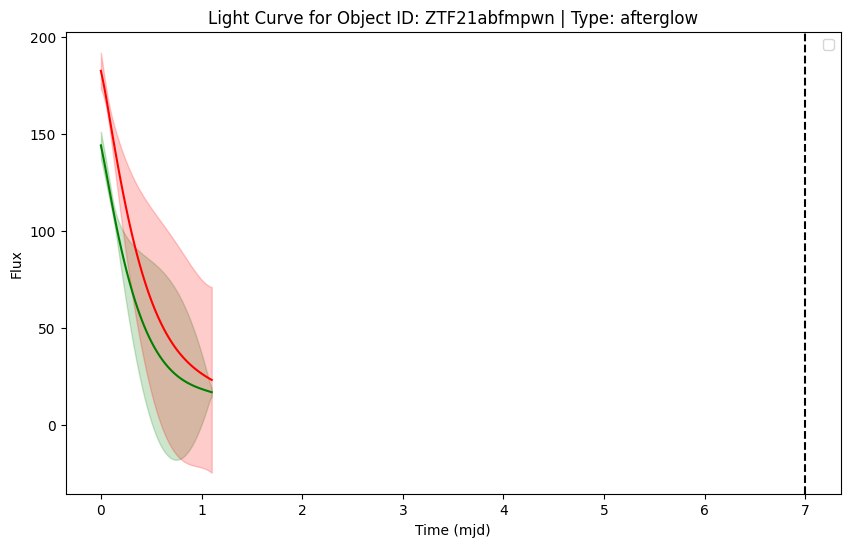

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


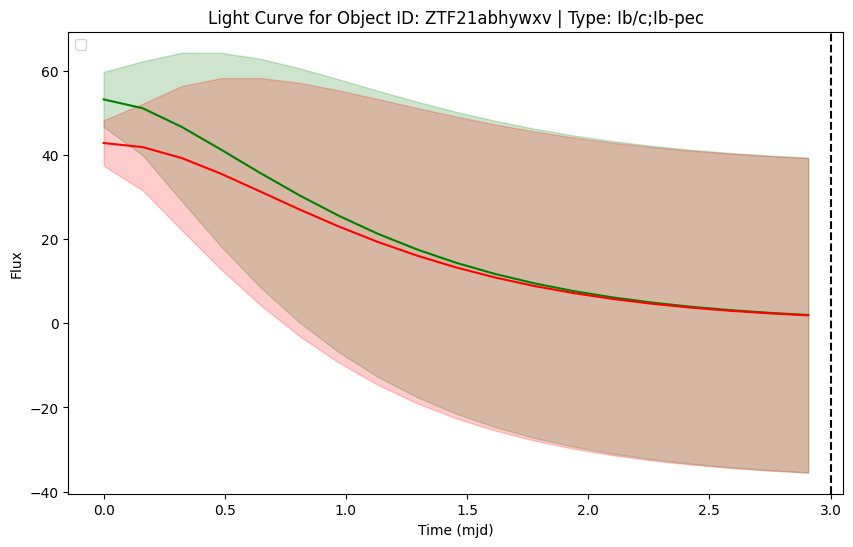

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


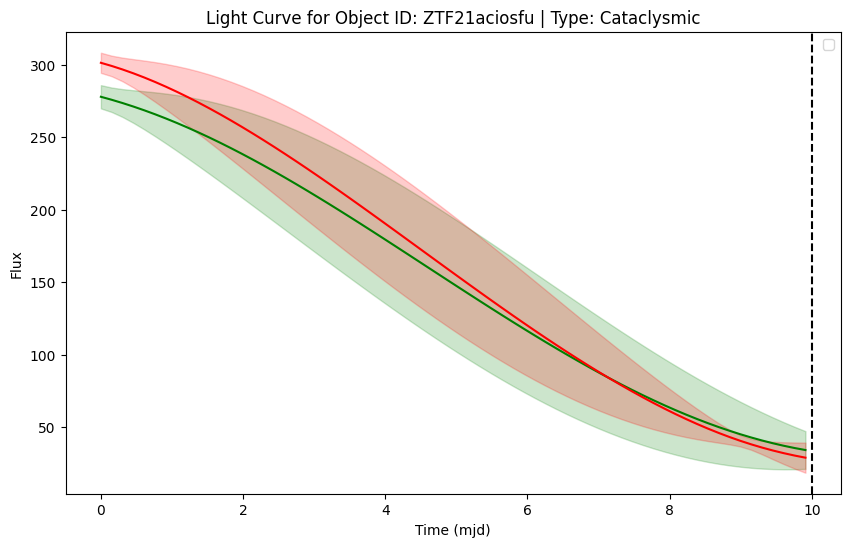

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


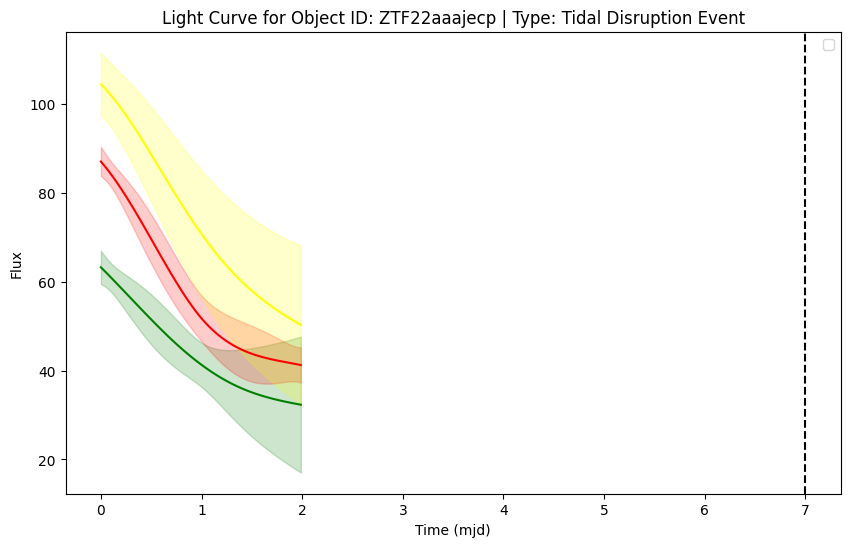

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


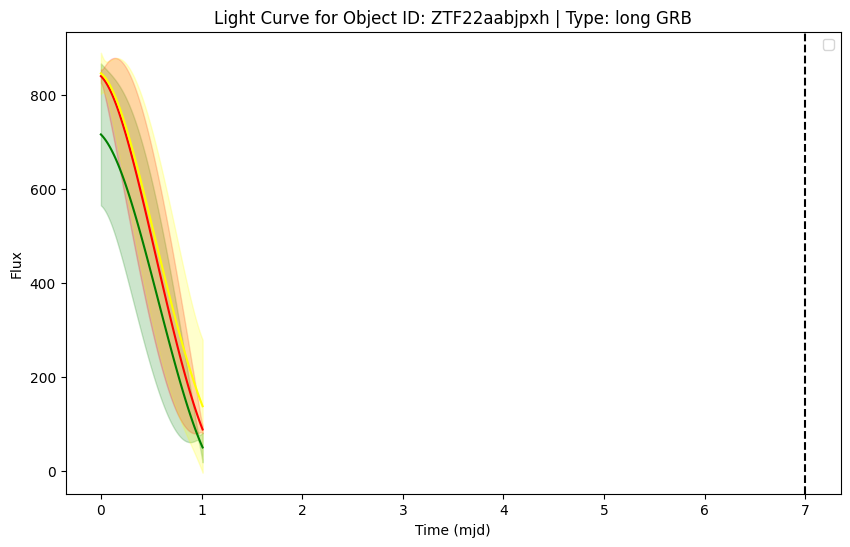

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


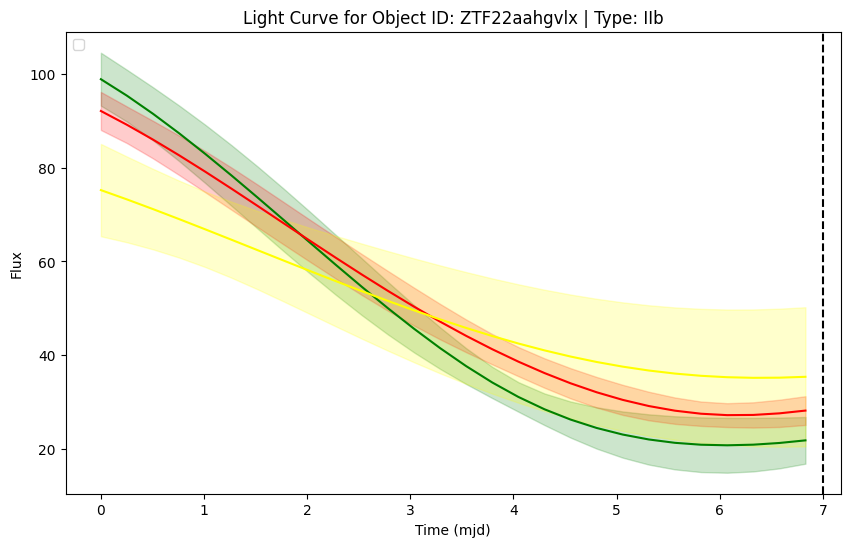

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


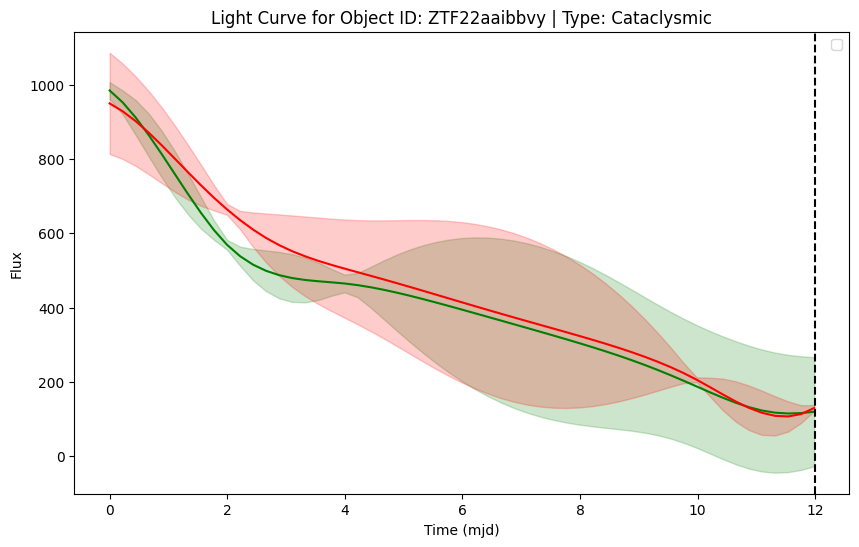

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


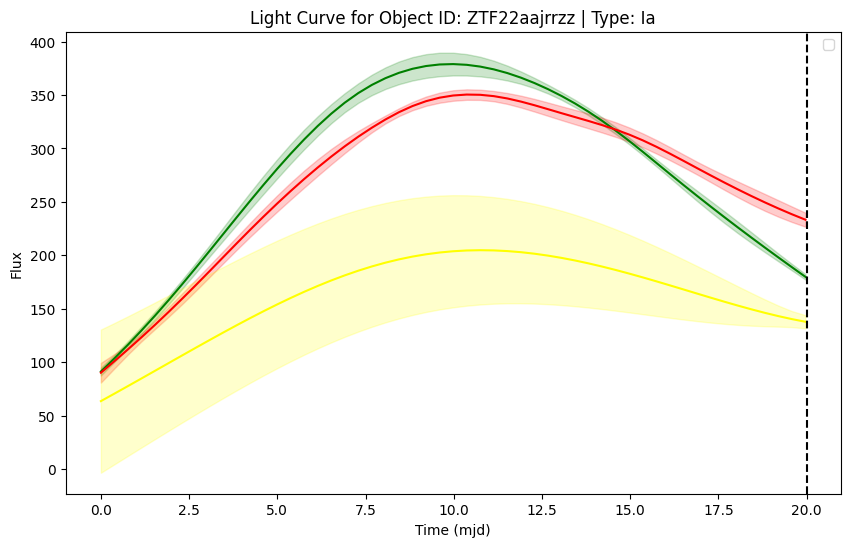

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


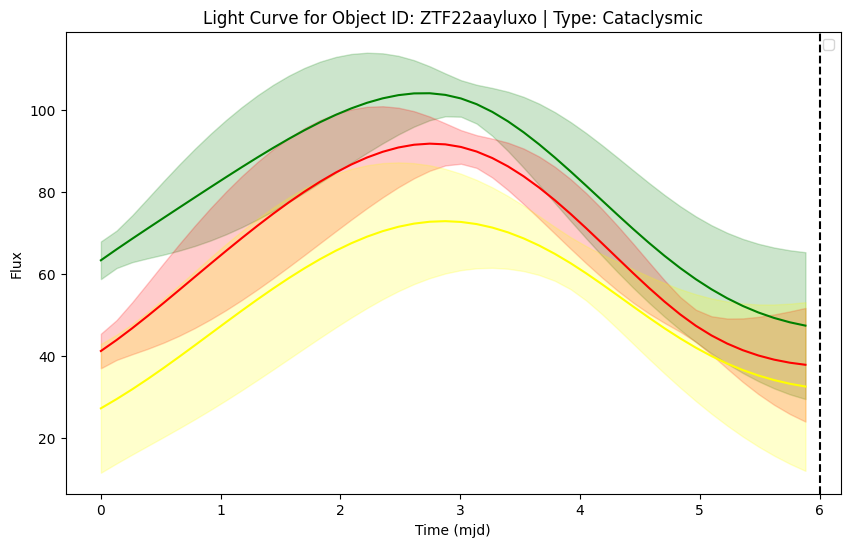

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


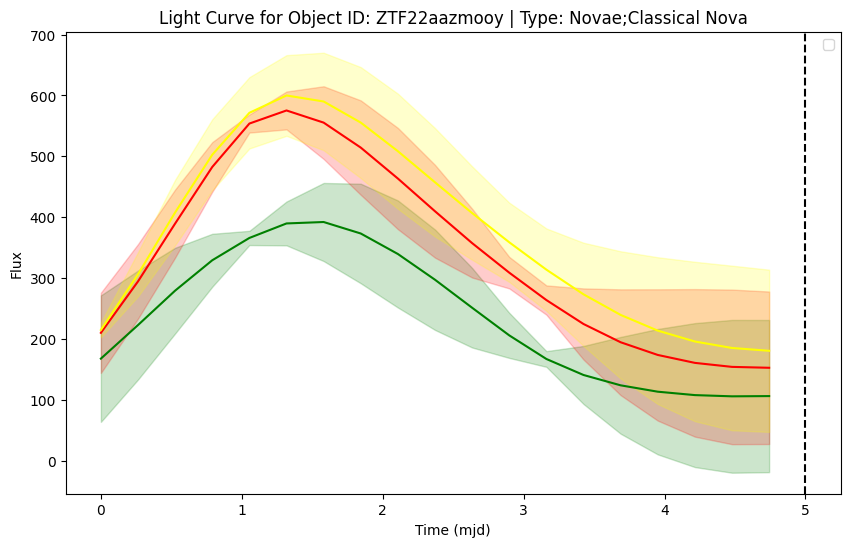

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


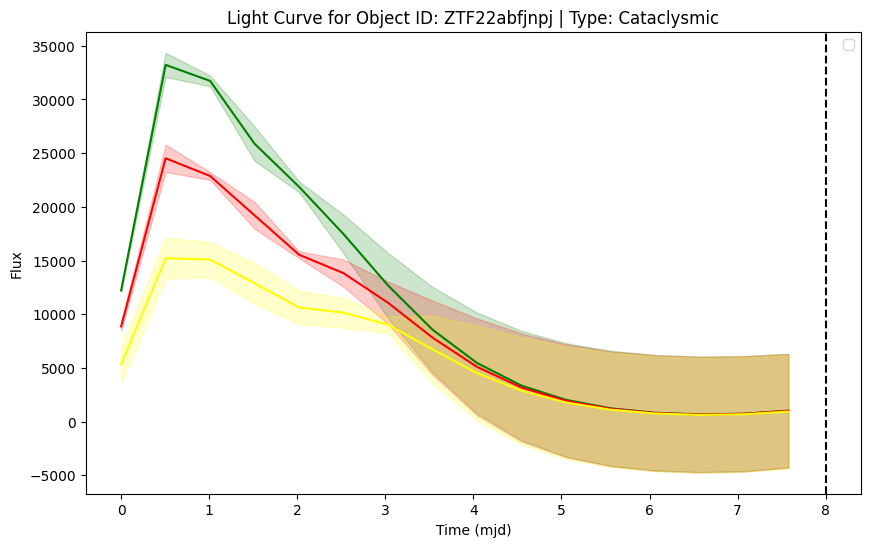

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


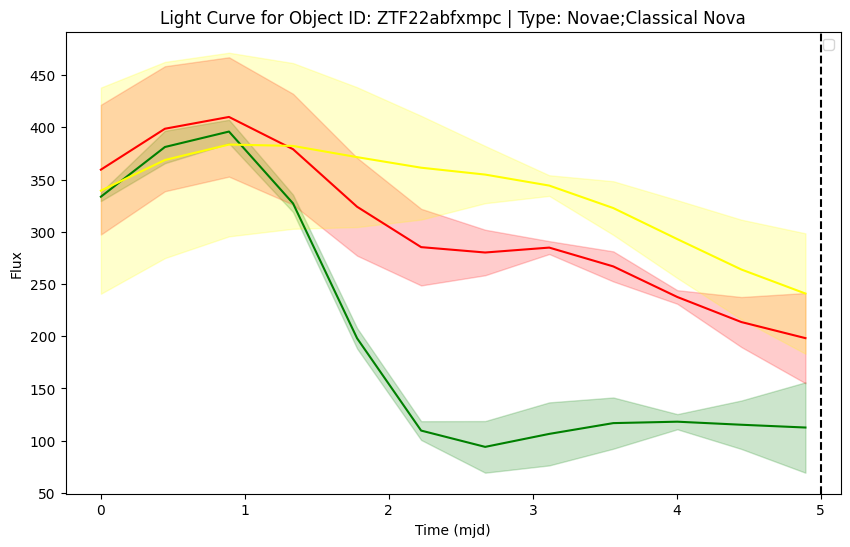

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


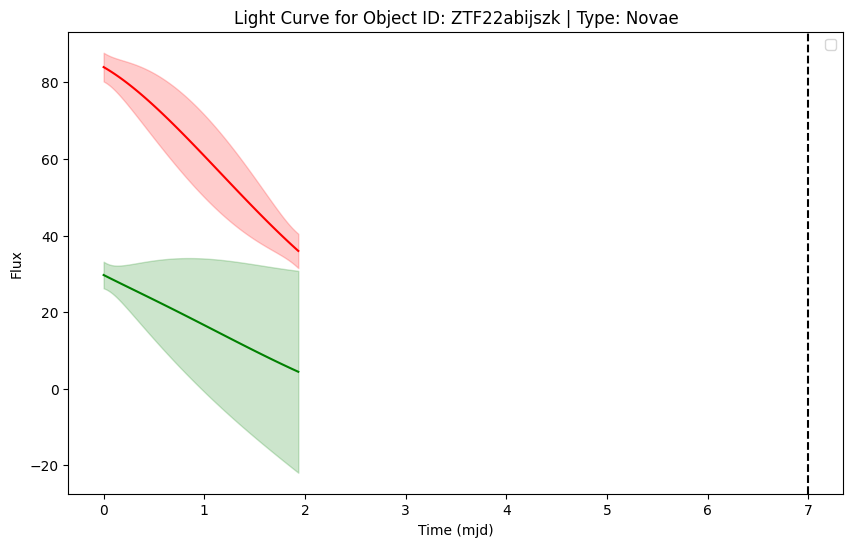

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


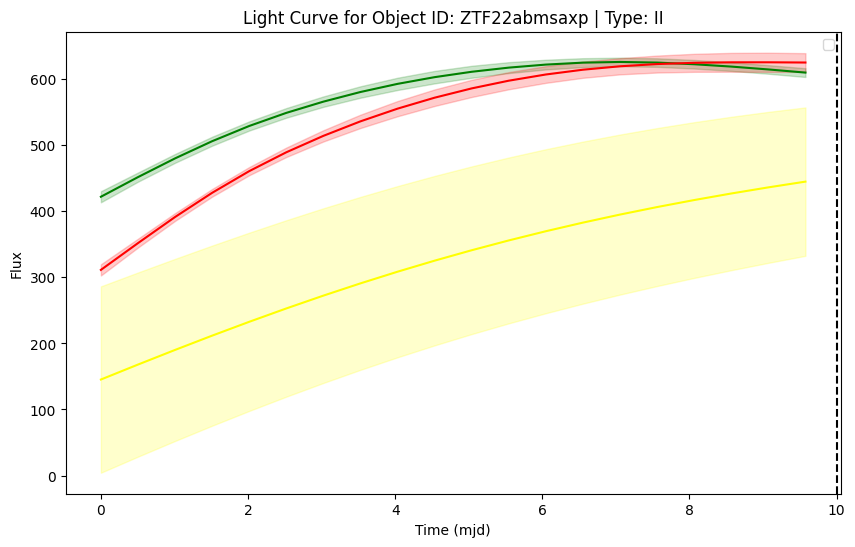

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


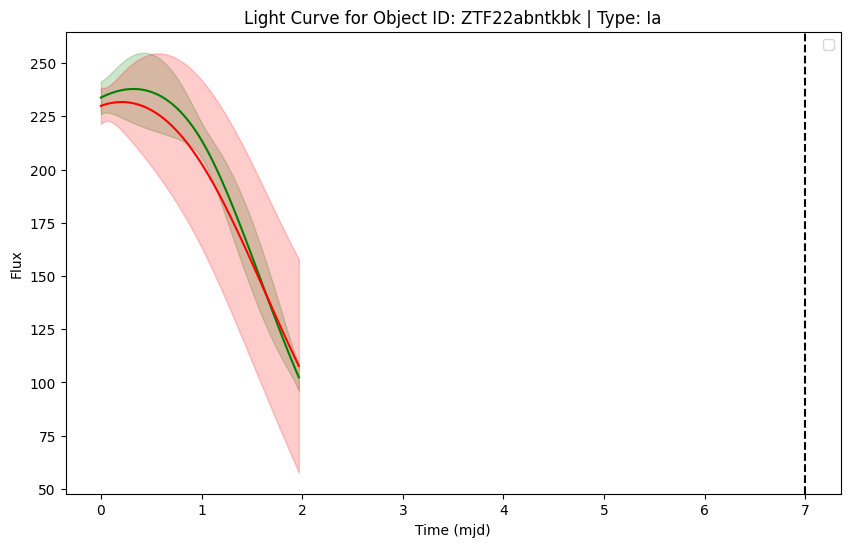

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


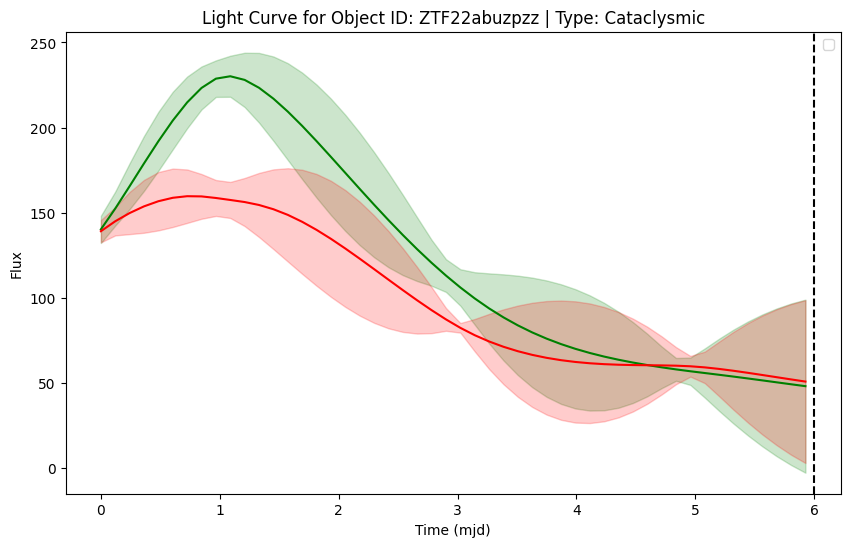

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


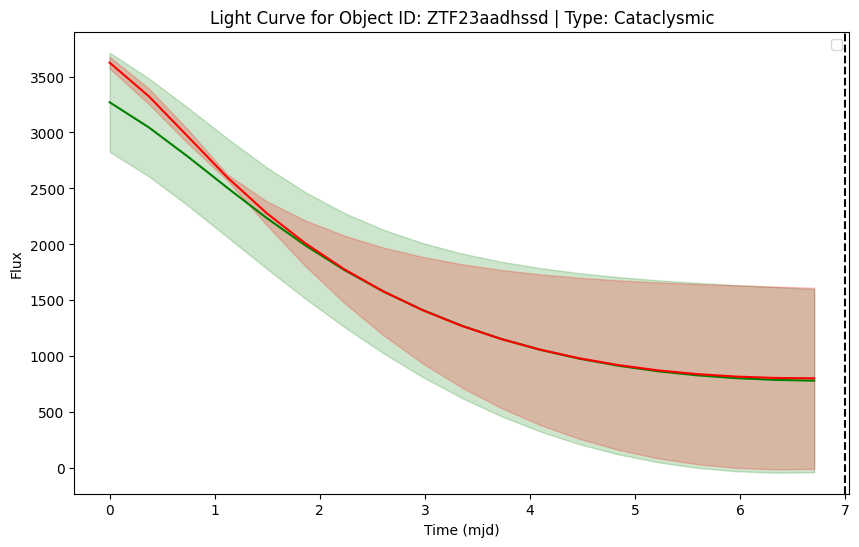

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


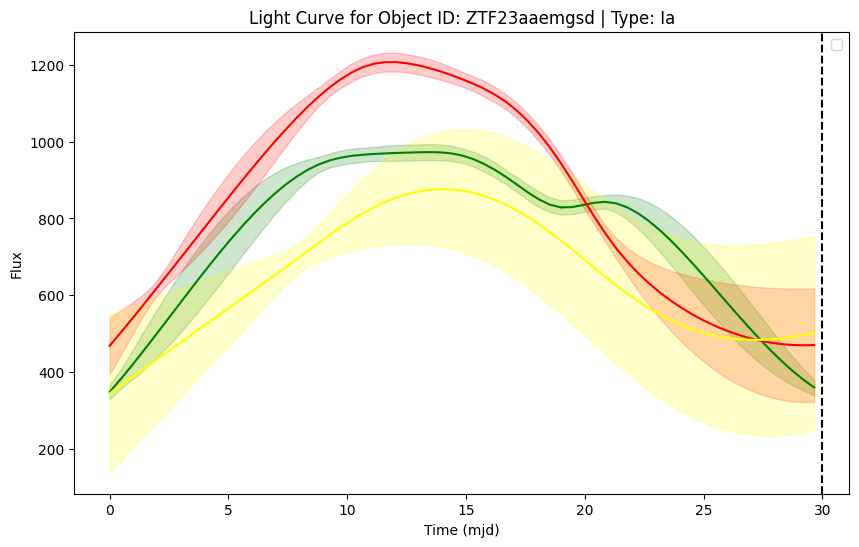

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


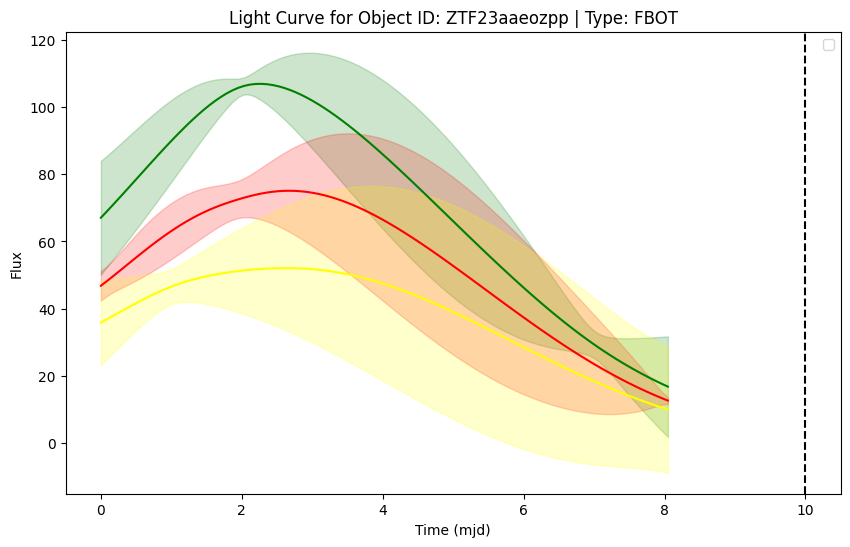

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


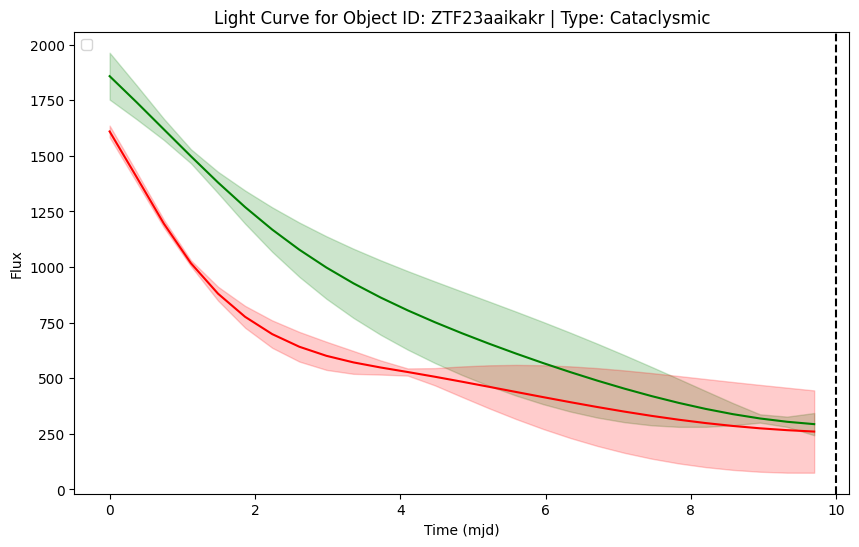

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


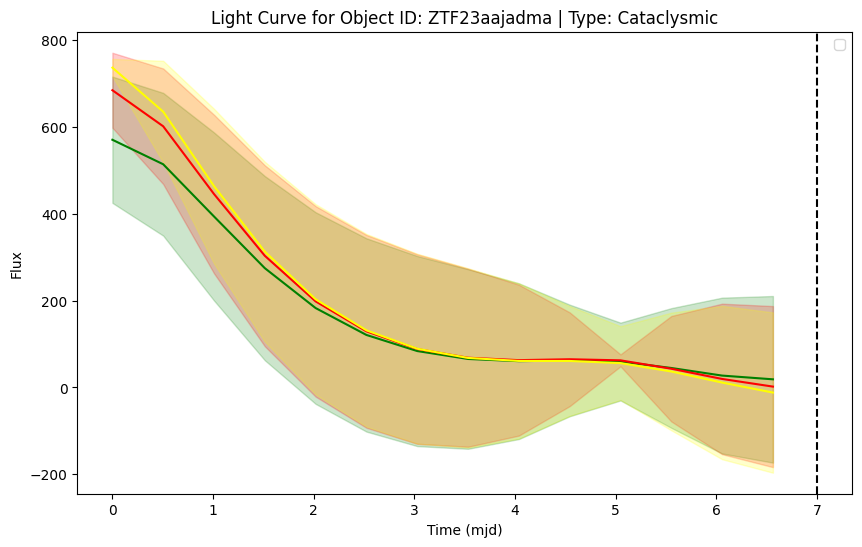

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


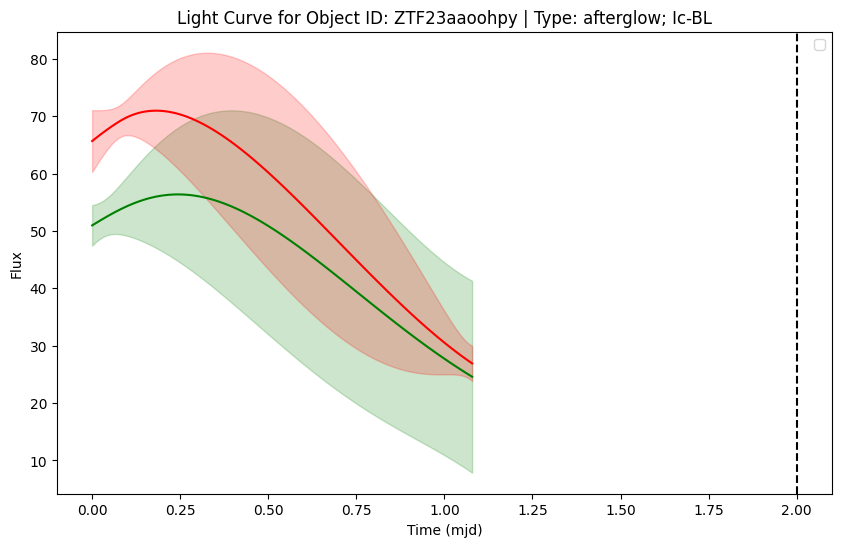

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


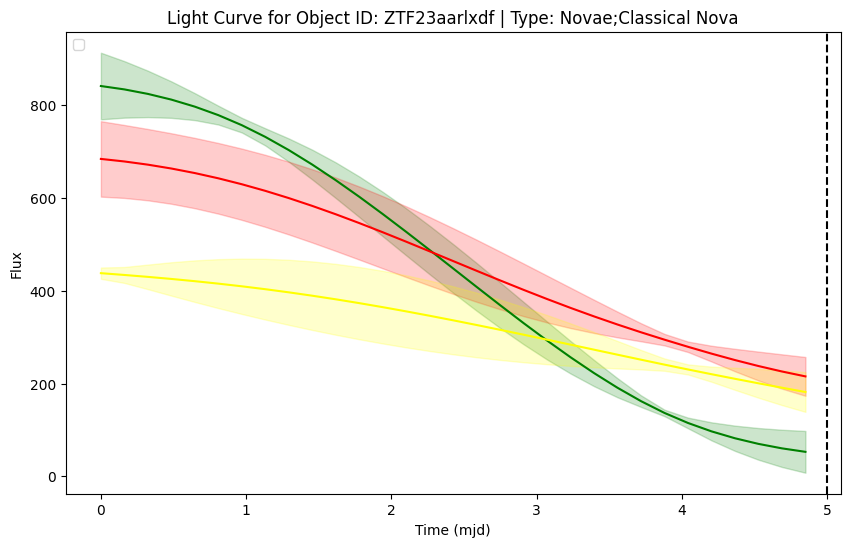

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


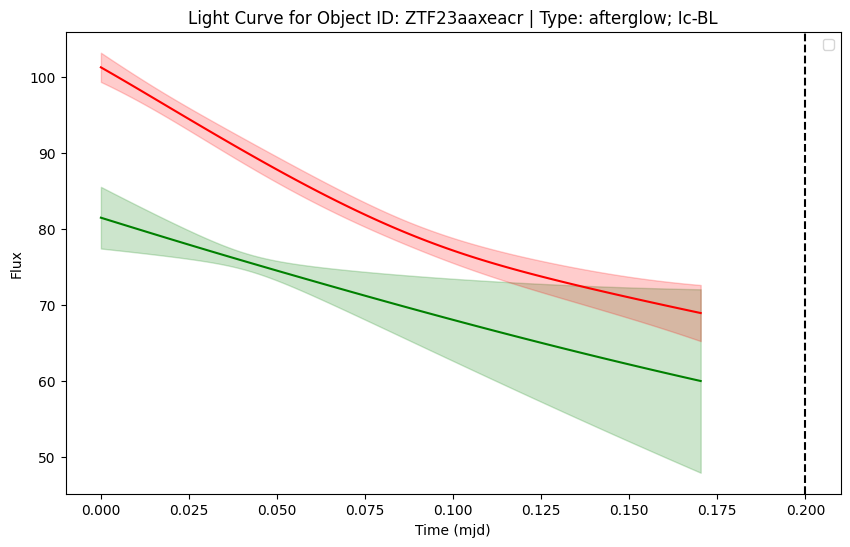

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


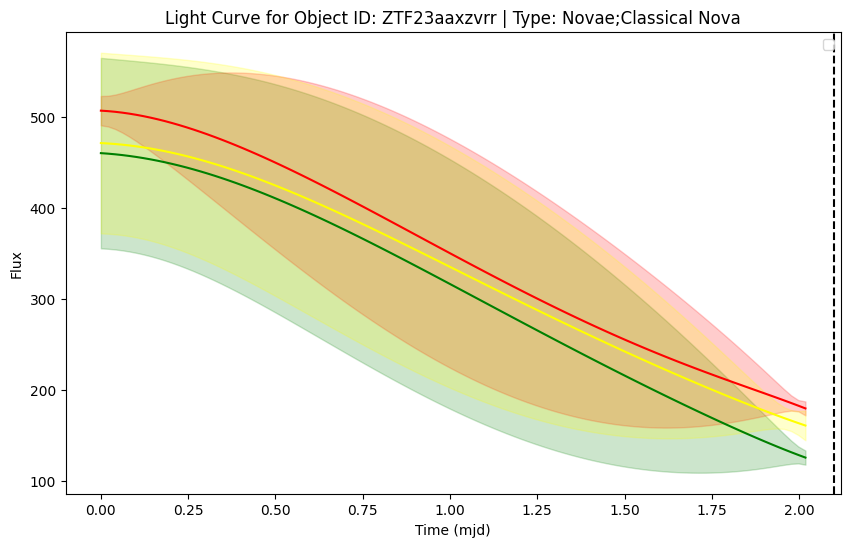

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


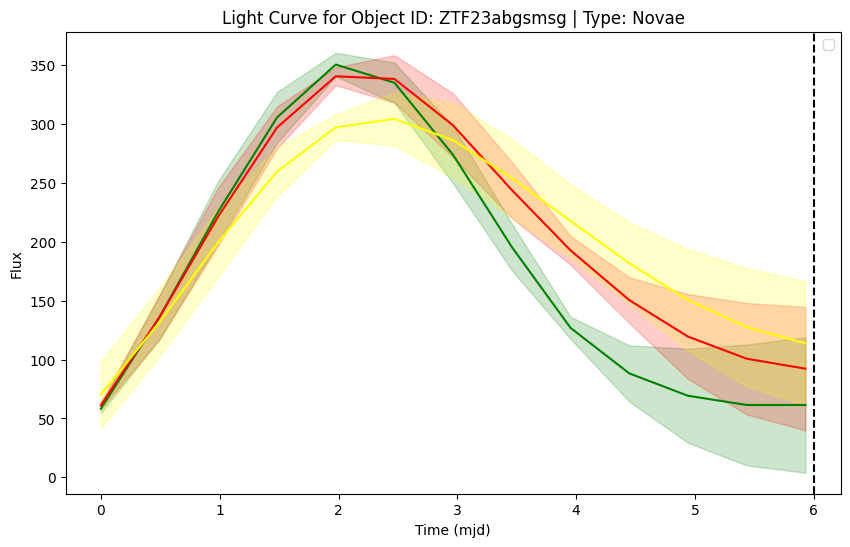

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


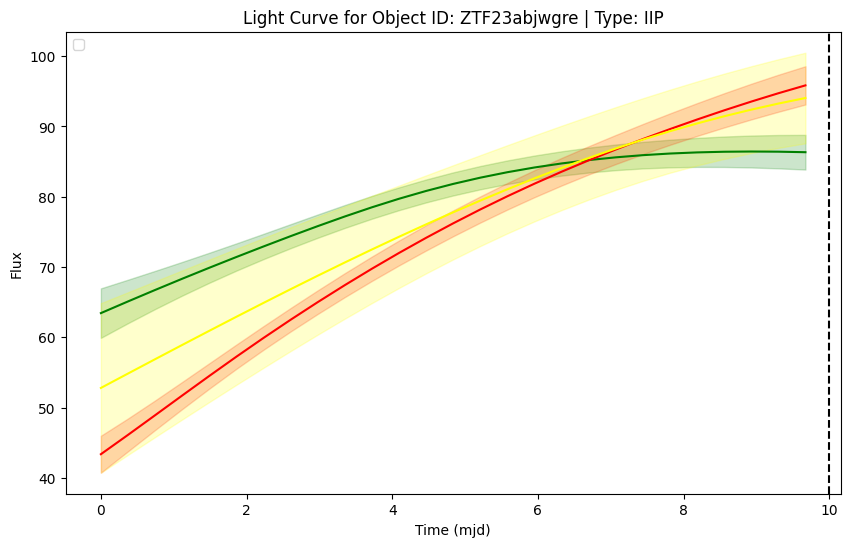

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


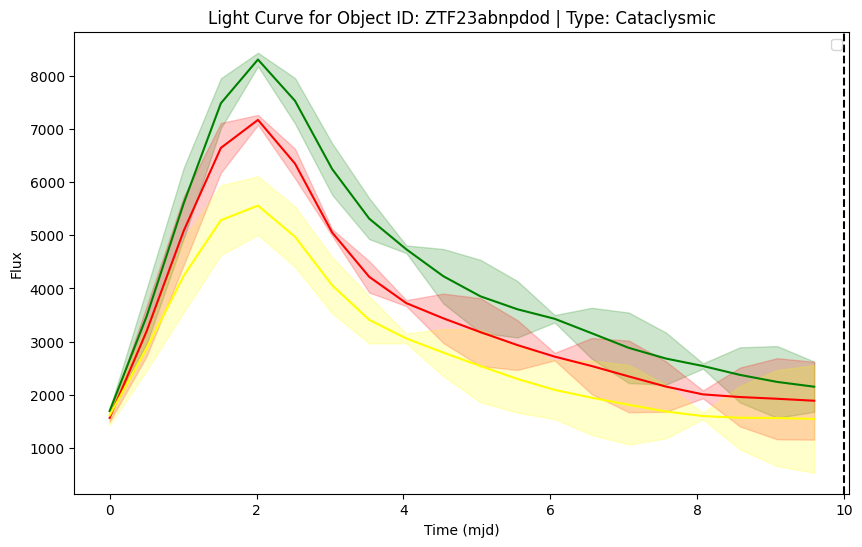

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


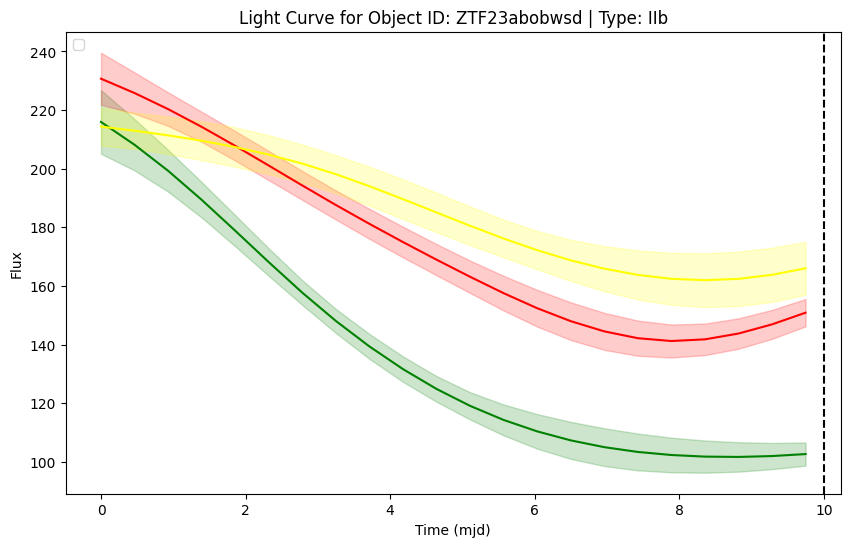

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


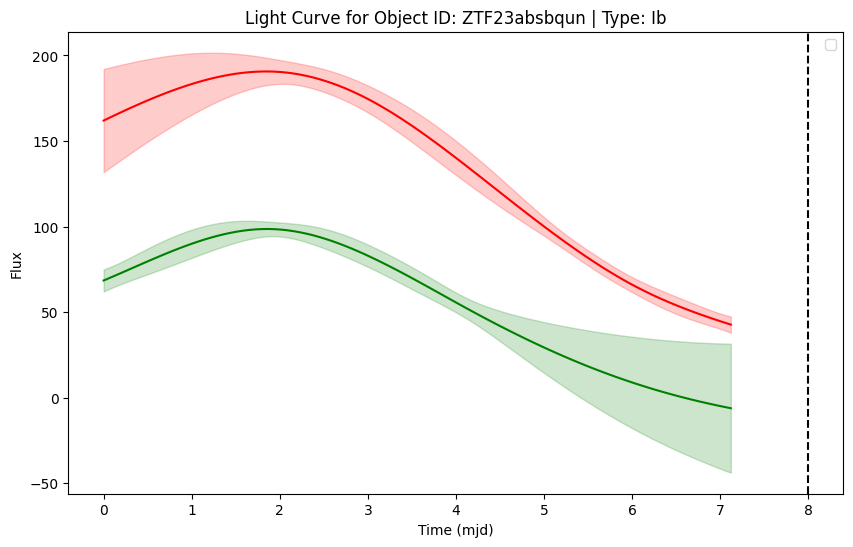

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


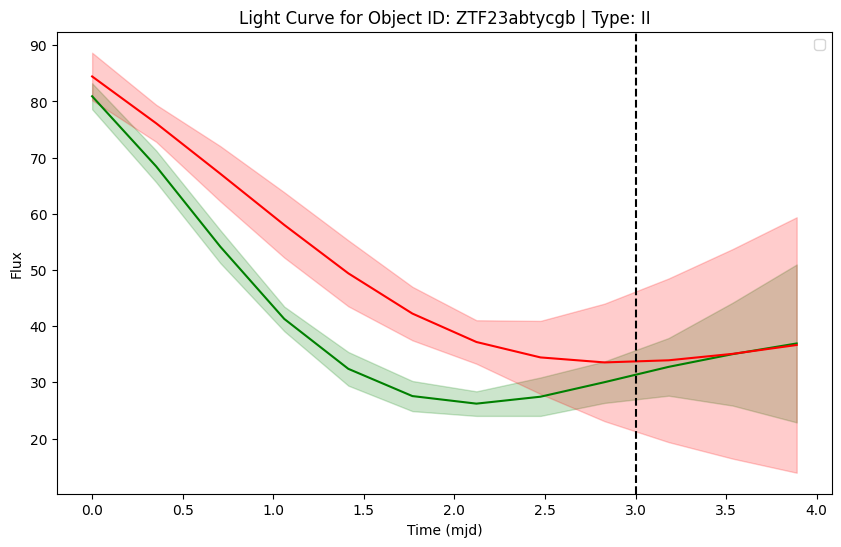

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


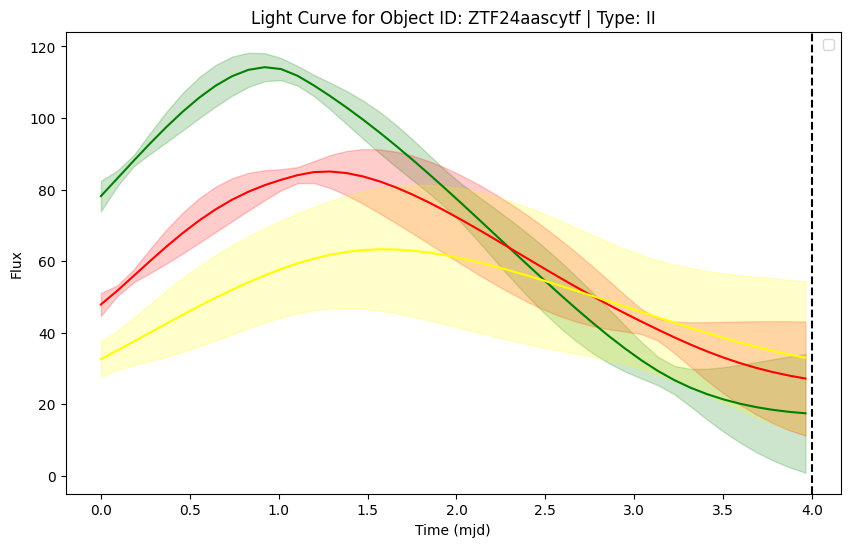

In [9]:
df = cut_data(df,obj[0], 15)
df = cut_data(df,obj[1], 10)
df = cut_data(df,obj[2], 10)
df = cut_data(df,obj[3], 12)
df = cut_data(df,obj[4], 12)
df = cut_data(df,obj[5], 23)
df = cut_data(df,obj[6], 15)
df = cut_data(df,obj[7], 12)
df = cut_data(df,obj[8], 6)
df = cut_data(df,obj[9], 5)
df = cut_data(df,obj[10], 25)
df = cut_data(df,obj[11], 11)
df = cut_data(df,obj[12], 10)
df = cut_data(df,obj[13], 20)
df = cut_data(df,obj[14], 6)
df = cut_data(df,obj[15], 10)
df = cut_data(df,obj[16], 13)
df = cut_data(df,obj[17], 20)
df = cut_data(df,obj[18], 10)
df = cut_data(df,obj[19], 25)
df = cut_data(df,obj[20], 10)
df = df[df['obj_id'] != obj[21]] ## ztfabwysqy not suited to GP
df = cut_data(df,obj[22], 25)
df = cut_data(df,obj[23], 8)
df = cut_data(df,obj[24], 35)
df = cut_data(df,obj[25], 6)
df = cut_data(df,obj[26], 5)
df = cut_data(df,obj[27], 2)
df = cut_data(df,obj[28], 10)
df = cut_data(df,obj[29], 30)
df = cut_data(df,obj[30], 8)
df = cut_data(df,obj[31], 6)
df = cut_data(df,obj[32], 4)
df = cut_data(df,obj[33], 3)
df = cut_data(df,obj[34], 6)
df = cut_data(df,obj[35], 3.1)
df = cut_data(df,obj[36], 40)
df = cut_data(df,obj[37], 7)
df = cut_data(df,obj[38], 7)
df = cut_data(df,obj[39], 3)
df = cut_data(df,obj[40], 10)
df = cut_data(df,obj[41], 7)
df = cut_data(df,obj[42], 7)
df = cut_data(df,obj[43], 7)
df = cut_data(df,obj[44], 12)
df = cut_data(df,obj[45], 20)
df = cut_data(df,obj[46], 6)
df = cut_data(df,obj[47], 5)
df = cut_data(df,obj[48], 8)
df = cut_data(df,obj[49], 5)
df = cut_data(df,obj[50], 7)
df = cut_data(df,obj[51], 10)
df = cut_data(df,obj[52], 7)
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 10)
df = cut_data(df,obj[68], 10)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)

In [10]:
# df.to_csv('gp_objects(downsample).csv', index=False)